In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""Vehicles Routing Problem (VRP)."""
from __future__ import print_function
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

## My functions

In [3]:
def manhattandist(a,b):
    '''
    compute manhattan distance between two points
    '''
    x1,y1 = a
    x2,y2 = b
    return (abs(x1-x2)+abs(y1-y2))

## Generate the points - route
def initpoints(origin, vehpos):
    '''
    function to initialize the points with origin and vehicle positions
    '''
    point = []
    
    # first point is the origin
    point = [origin]
    
    #append the vehicle positions
    for vh in vehpos:
        point.append(vh)
        
    print ('origin and vehicle positions are', point)
    assert (len(point) == 1 + len(vehpos)), 'Init points, number of points do not match'
    return (point)

def genpoints(point, numpoints):
    '''
    function to generate the points arbitrarily and append them to existing list
    '''

    x = np.random.randint(0,100,numpoints)
    y = np.random.randint(0,100,numpoints)
    
    newadd = []
    
    for (a,b) in zip(x,y):
        point.append((a,b))
        newadd.append((a,b))        
    
    return (point, newadd)

def modifypoints(points, points_covered, origin, vehicle_position):
    
    #print (points)
    #print (points_covered)
    
    newp = [origin]    
    
    for vh in vehicle_position:
        newp.append(vh)
    
    #print (newp)
    
    covlist = []
    for pcov in points_covered:
        covlist.append(points[pcov])
    #print (covlist)
    
    # starts from 5 because 1 origin + 4 vehicles
    for pts in points[5:]:
        if pts in covlist:
            pass
        else:
            newp.append(pts)
            
    assert (len(points) - len(covlist) == len(newp)), 'Number of points covered does not add up'
    return (newp, covlist)

def gendistmat(point):
    '''
    function to generate distance matrix between the points
    '''
    
    distmat = np.zeros((len(point), len(point)))
    
    for i in range(len(point)):
        for j in range(len(point)):
            origin = point[i]
            dest = point[j]
            distmat[i][j] = manhattandist(origin, dest)
            
    return(distmat)

# Plotting functions

In [4]:
#plot the points
def plotpoints(points, newpoints, filename, covpoints=[], nvehicles=4, title = 'stops at t=0 minutes'):
    
    orig = points[0]
    plt.clf()
    plt.figure(figsize=(15,8))
    plt.subplots_adjust(right=0.8)
    plt.scatter(orig[0], orig[1], marker='s', color='magenta',s=100, label='Depot')
    
    for i in range(1, 5):
        p = points[i]
        if (i==1):
            plt.scatter(p[0], p[1], marker = 'D', color='orange', s=100,  label='Vehicle')
        else:
            plt.scatter(p[0], p[1], marker = 'D', color='orange',  s=100)
        
    escnt = 0
    for i in range(5, len(points)):
        p = points[i]  
        if (p in newpoints):
            pass
        else:
            if (escnt == 0):
                plt.scatter(p[0], p[1], color='k', label='Existing Stop', s=100)
                escnt += 1
            else:
                plt.scatter(p[0], p[1], color='k', s=100)
        
    for i in range(len(newpoints)):
        p = newpoints[i]
        if (i==0):
            plt.scatter(p[0], p[1], marker = 'o',  color='y', edgecolor='red', s=100, label='New Stop')
        else:
            plt.scatter(p[0], p[1], marker = 'o',  color='y', edgecolor='red', s=100)
        
        
    if covpoints:
        cnt = 0
        for cc in covpoints:
            if (cnt == 0):
                plt.scatter(cc[0], cc[1], marker = 'P', color='green', label = 'Covered Stops')
                cnt += 1
            else:
                plt.scatter(cc[0], cc[1], marker = 'P', color='green')
                
    plt.xlim(-2,102)
    plt.ylim(-2,102)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.plot()
    plt.savefig(filename)
    return ()

[(40, 60), (40, 60), (40, 60), (40, 60)]
origin and vehicle positions are [(40, 60), (40, 60), (40, 60), (40, 60), (40, 60)]
20


()

<Figure size 432x288 with 0 Axes>

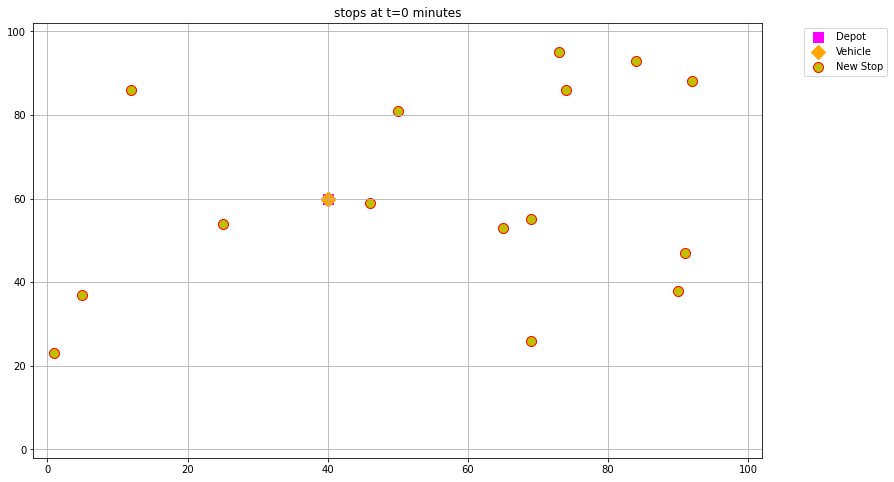

In [5]:
# Setting up the first problem
numpoints = 15
numvehicles = 4
origin = (40,60)
vehpos = numvehicles * [origin]
print (vehpos)

points = initpoints(origin, vehpos)
points, newadd = genpoints(points, numpoints)
distmat = gendistmat(points)
npoints = len(points)
print (npoints)
plotpoints(points, newadd, 'sample.png')

In [6]:
def create_data_model_v2d(distmat):
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = distmat
    data['num_vehicles'] = 4
    data['starts'] = [1, 2, 3, 4]
    data['ends'] = [0, 0, 0, 0]
    return data

In [7]:
def return_solution(data, manager, routing, solution):
    routelist = []
    for vehicle_id in range(data['num_vehicles']):
        vehiclelist = []
        index = routing.Start(vehicle_id)
        #print ('vehicle ID and starting index are', vehicle_id, index)
        vehiclelist.append(index)
        #print ('vehicle list', vehiclelist)
        while not routing.IsEnd(index):
            #index = manager.IndexToNode(index)
            index = solution.Value(routing.NextVar(index))
            vehiclelist.append(index)
            #print ('vehicle list', vehiclelist)
        routelist.append(vehiclelist)
    return (routelist)

def cleanpoints(rl, numpoints):
    newrl  = []
    for listt in rl:
        for indx in range(len(listt)):
            if (listt[indx] >= numpoints):
                listt[indx] = 0
        newrl.append(listt)
                
    return (newrl)

def cleanpoints_v2p(rl, numpoints):
    newrl  = []
    for listt in rl:
        #print ('before update', listt)
        for indx in range(len(listt)):
            listt[indx] += 1
            if (listt[indx] >= numpoints):
                listt[indx] = 0
            
            #if listt[indx] > 0:
            #
                
        listt[-1] = 0
        
        #print ('after update', listt)
        newrl.append(listt)
                
    return (newrl)

In [8]:
def plotroutes(points, crl,filename, title='routes at t=0 minutes'):
    colors= ['red', 'blue', 'green', 'cyan']
    
    plt.clf()
    plt.figure(figsize=(15,8))
    plt.subplots_adjust(right=0.8)
    
    pcnt = 1
    for masindx in range(len(crl)):
        co = colors[masindx]
        vehroute = crl[masindx]
        print (masindx, co, vehroute)
        repcnt = 0
        for subindx in range(1, len(vehroute)):            
            orig = points[vehroute[subindx-1]]
            dest = points[vehroute[subindx]]
            x = [orig[0], dest[0]]
            y = [orig[1], dest[1]]
            plt.scatter(orig[0], orig[1], color = 'k', s=100)
            plt.scatter(dest[0], dest[1], color = 'k', s=100)
            if (repcnt == 0):    
                strng = 'Route ' + str(pcnt)
                plt.plot(x, y, color = co, label = strng, lw=2)
                repcnt += 1
            else:
                plt.plot(x, y, color = co)
            
        pcnt += 1
    
    orig = points[0]
    plt.scatter(orig[0], orig[1], marker= 's', color = 'magenta', s=100)
    #plt.axes().set_aspect('equal', 'datalim')
    plt.title(title)
    plt.xlim(-2,102)
    plt.ylim(-2,102)
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig(filename)
    plt.show()

## Google OR tools functions

In [9]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    max_route_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print('Maximum of the route distances: {}m'.format(max_route_distance))

In [10]:
## Solution from Vehicle to Depot
def main_v2d(distmat):
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model_v2d(distmat)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['starts'],
                                           data['ends'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)
        
    # Send solution out
    #if solution:
        #return_solution(data, manager, routing, solution)
        
    return (data, manager, routing, solution)

# Test Scenario 2

In [11]:
data2, manager2, routing2, solution2 = main_v2d(distmat)

Route for vehicle 0:
 1 ->  11 ->  12 ->  17 ->  8 ->  9 ->  6 -> 0
Distance of the route: 170m

Route for vehicle 1:
 2 ->  14 ->  18 ->  15 ->  19 ->  7 -> 0
Distance of the route: 174m

Route for vehicle 2:
 3 ->  10 -> 0
Distance of the route: 108m

Route for vehicle 3:
 4 ->  16 ->  13 ->  5 -> 0
Distance of the route: 152m

Maximum of the route distances: 174m


In [12]:
rl2 = return_solution(data2, manager2, routing2, solution2)
crl2 = cleanpoints_v2p(rl2, npoints)
print (crl2)

[[1, 11, 12, 17, 8, 9, 6, 0], [2, 14, 18, 15, 19, 7, 0], [3, 10, 0], [4, 16, 13, 5, 0]]


0 red [1, 11, 12, 17, 8, 9, 6, 0]
1 blue [2, 14, 18, 15, 19, 7, 0]
2 green [3, 10, 0]
3 cyan [4, 16, 13, 5, 0]


<Figure size 432x288 with 0 Axes>

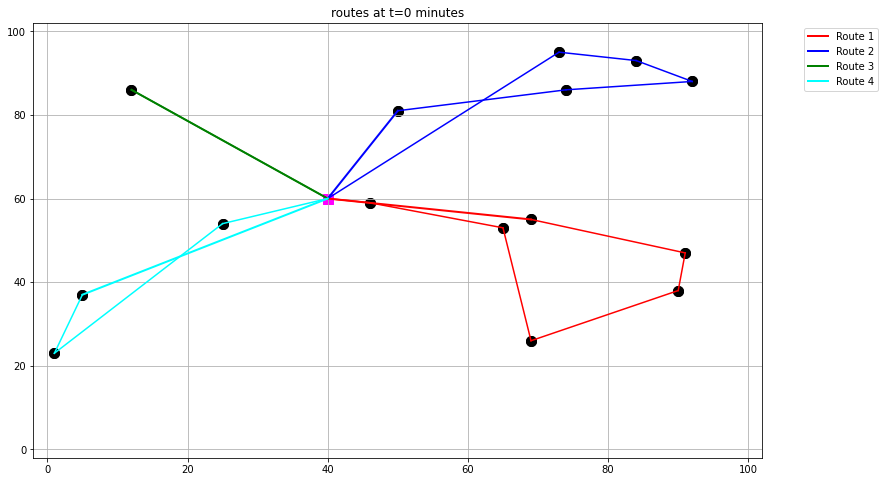

In [13]:
plotroutes(points, crl2, 'routes.png')

In [14]:
def vehtripstatus(crl, points, distmat, vehid, time, speed):
    
    ## locate the vehicle at time t
    covdist = time * speed
    #print (covdist)

    rte = crl[vehid]
    #print (rte)
    ptscovered = []
    #print (rte)
    distsum = 0
    completed_dist = 0
    i = 0
    
    if (len(rte) > 2):
    
        while (covdist > distsum) & (i < len(rte)):
            i+= 1
            orig= rte[i-1]
            dest = rte[i]
            dist = distmat[orig][dest]
            #print (orig, dest, dist)
            distsum += dist
            if (distsum < covdist):
                ptscovered.append(dest)
                completed_dist += dist

        #print (distsum, completed_dist)
        #print (rte, ptscovered)

        truckloc = covdist - completed_dist
        #print (truckloc, dist)

        #print (points[orig], points[dest])
        tx = points[orig][0] + (truckloc/dist) * (points[dest][0]-points[orig][0])
        ty = points[orig][1] + (truckloc/dist) * (points[dest][1]-points[orig][1])
        #print (tx, ty)
        tx = round(tx, 1)
        ty = round(ty, 1)
        
    else:
        tx = 0
        ty = 0
    
    return (ptscovered, tx, ty)

def tottripstatus(crl, points, distmat, time, speed):
    ptscov = []
    vehpos = []
    #print (len(crl))
    for vehid in range(len(crl)):
        cov, vehx, vehy = vehtripstatus(crl, points, distmat, vehid, time, speed)
        #print ('~~~~~~~~~~', cov, vehx, vehy)
        vehpos.append((vehx, vehy))
    
        if cov:
            for i in cov:
                ptscov.append(i)
    
    return (ptscov, vehpos)

# Plotting functions

In [15]:
def plottripstatus(crl, points, visited, vehpos, filename = 'image.png', title = 'trip status at t=0 minutes'):
    colors= ['red', 'blue', 'green', 'cyan']
        
    plt.clf()
    plt.figure(figsize=(15,8))
    plt.subplots_adjust(right=0.8)
    
    orig = points[0]
    plt.scatter(orig[0], orig[1], marker= 's', color = 'magenta', label = 'Depot', s=100)
    
    vhcnt = 0
    for vh in vehpos:
        if (vhcnt == 0):
            plt.scatter(vh[0], vh[1], marker= 'D', color = 'orange', label = 'Vehicle', s=100)
            vhcnt += 1
        else:
            plt.scatter(vh[0], vh[1], marker= 'D', color = 'orange', s=100)
    
    nvcnt = 0
    vcnt = 0
    for masindx in range(len(crl)):
        co = colors[masindx]
        vehroute = crl[masindx]
        print (masindx, co, vehroute)
        for subindx in range(1, len(vehroute)):
            orig = points[vehroute[subindx-1]]
            dest = points[vehroute[subindx]]
            x = [orig[0], dest[0]]
            y = [orig[1], dest[1]]
            if (vehroute[subindx-1] not in visited):
                if (nvcnt == 0):
                    plt.scatter(orig[0], orig[1], color = 'k', label = 'Exisiting stops', s=100)
                    nvcnt += 1
                else:
                    plt.scatter(orig[0], orig[1], color = 'k', s=100)
            if (vehroute[subindx] not in visited):
                plt.scatter(dest[0], dest[1], color = 'k')
            plt.plot(x, y, color = co)
    
    for v in visited:
        pt = points[v]
        if (vcnt == 0):
            plt.scatter(pt[0], pt[1], color = 'green', marker = 'P', label = 'Completed stops', s=100)
            vcnt += 1
        else:
            plt.scatter(pt[0], pt[1], color = 'green', marker = 'P', s=100)
    
    
    
    plt.xlim(-2,102)
    plt.ylim(-2,102)
    plt.grid(True)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig(filename)
    plt.show()
    plt.clf()
    return ()

In [16]:
def plot5minints(crl2, points, distmat, starttime, endtime, offset, speed):
    
    #convert hour duration to minutes
    ints = (endtime - starttime)*60
    nsteps = range(0, ints+1, 5)
    
    for i in nsteps[1:]:
        tmins = (starttime*60 + i)
        t = tmins/60
        truetime = offset*60 + tmins
        filename = 'soln-at-time-' + str(truetime).zfill(3)+'.png'
        title = 'trip status at ' + str(truetime) +' minutes'
        print (filename)
        pc, vp = tottripstatus(crl2, points, distmat, t, speed)
        plottripstatus(crl2, points, pc, vp, filename, title)
        
    return ()

In [17]:
def plottripwithnewpoints(crl, points, visited, vehpos, newadd, filename = 'image.png',
                          title = 'route and new stops at t=0 minutes'):
    colors= ['red', 'blue', 'green', 'cyan']
    
    plt.clf()
    plt.figure(figsize=(15,8))
    plt.subplots_adjust(right=0.8)
    
    orig = points[0]
    plt.scatter(orig[0], orig[1], marker= 's', color = 'magenta', label = 'Depot', s=100)
    
    vhcnt = 0
    for vh in vehpos:
        if (vhcnt == 0):
            plt.scatter(vh[0], vh[1], marker= 'D', color = 'orange', label = 'Vehicle', s=100)
            vhcnt += 1
        else:
            plt.scatter(vh[0], vh[1], marker= 'D', color = 'orange', s=100)
    
    nvcnt = 0
    vcnt = 0
    for masindx in range(len(crl)):
        co = colors[masindx]
        vehroute = crl[masindx]
        print (masindx, co, vehroute)
        for subindx in range(1, len(vehroute)):
            
            orig = points[vehroute[subindx-1]]
            dest = points[vehroute[subindx]]
            x = [orig[0], dest[0]]
            y = [orig[1], dest[1]]
            if (vehroute[subindx-1] not in visited):
                if (nvcnt == 0):
                    plt.scatter(orig[0], orig[1], color = 'k', label = 'Exisiting stops', s=100)
                    nvcnt += 1
                else:
                    plt.scatter(orig[0], orig[1], color = 'k', s=100)
                    
            if (vehroute[subindx] not in visited):
                plt.scatter(dest[0], dest[1], color = co, s=100)
            plt.plot(x, y, color = co)
    
    for v in visited:
        pt = points[v]
        if (vcnt == 0):
            plt.scatter(pt[0], pt[1], color = 'green', marker = 'P', label = 'Completed Stop', s=100)
            vcnt += 1
        else:
            plt.scatter(pt[0], pt[1], color = 'green', marker = 'P')

    newcnt = 0   
    for nw in newadd:
        if (newcnt == 0):
            plt.scatter(nw[0], nw[1], marker = 'o', color='none', edgecolor='red', s=100, label = 'New stop')
            newcnt += 1
        else:
            plt.scatter(nw[0], nw[1], marker = 'o', color='none', edgecolor='red', s=100)
        plt.scatter(nw[0], nw[1], marker = '.', color='yellow', s=100)
    
    plt.xlim(-2,102)
    plt.ylim(-2,102)
    plt.grid(True)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig(filename)
    plt.show()
    plt.clf()
    return ()

0 red [1, 11, 12, 17, 8, 9, 6, 0]
1 blue [2, 14, 18, 15, 19, 7, 0]
2 green [3, 10, 0]
3 cyan [4, 16, 13, 5, 0]


<Figure size 432x288 with 0 Axes>

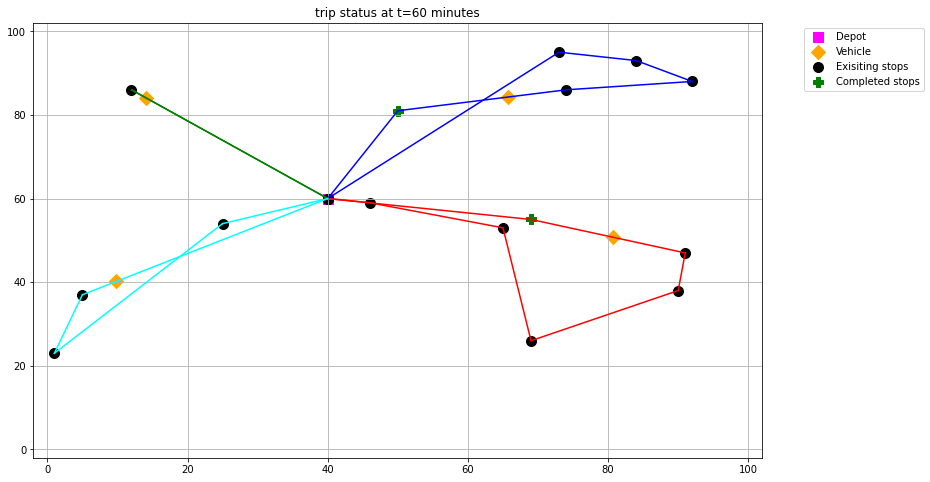

()

<Figure size 432x288 with 0 Axes>

In [18]:
pc, vp = tottripstatus(crl2, points, distmat, 1, 50)
plottripstatus(crl2, points, pc, vp, 'onehour.png', 'trip status at t=60 minutes')

soln-at-time-005.png
0 red [1, 11, 12, 17, 8, 9, 6, 0]
1 blue [2, 14, 18, 15, 19, 7, 0]
2 green [3, 10, 0]
3 cyan [4, 16, 13, 5, 0]


<Figure size 432x288 with 0 Axes>

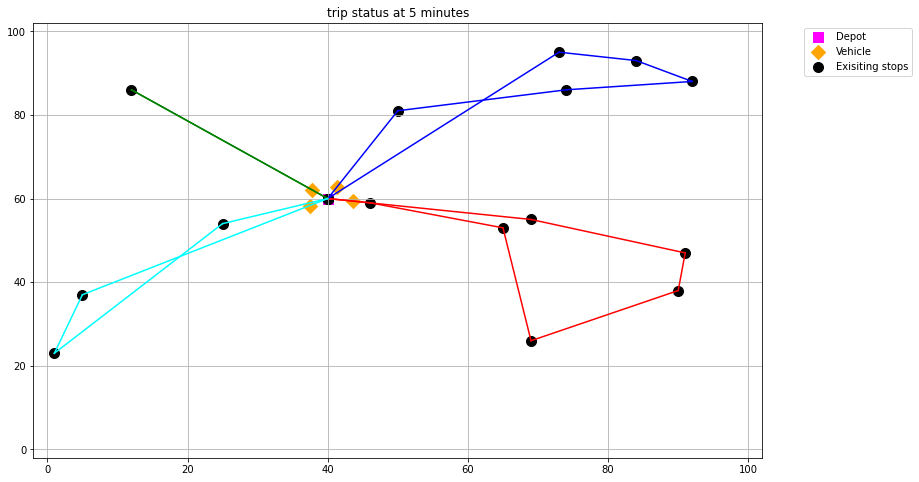

soln-at-time-010.png
0 red [1, 11, 12, 17, 8, 9, 6, 0]
1 blue [2, 14, 18, 15, 19, 7, 0]
2 green [3, 10, 0]
3 cyan [4, 16, 13, 5, 0]


<Figure size 432x288 with 0 Axes>

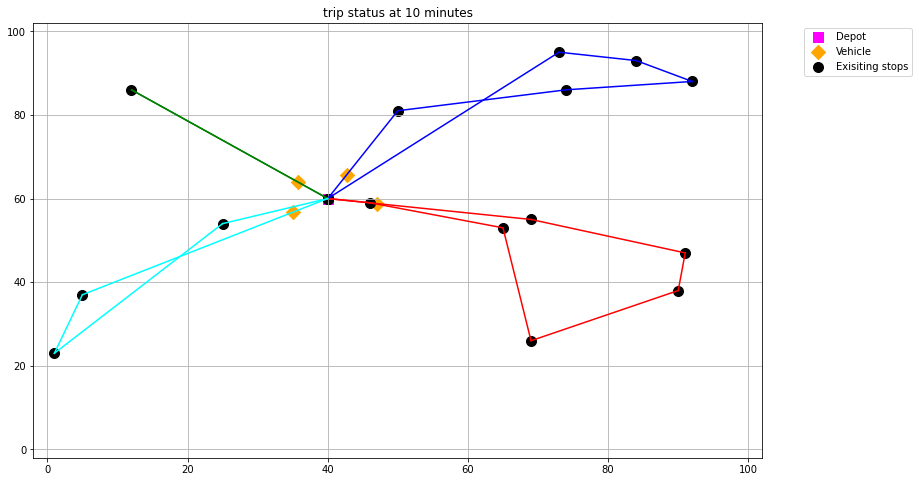

soln-at-time-015.png
0 red [1, 11, 12, 17, 8, 9, 6, 0]
1 blue [2, 14, 18, 15, 19, 7, 0]
2 green [3, 10, 0]
3 cyan [4, 16, 13, 5, 0]


<Figure size 432x288 with 0 Axes>

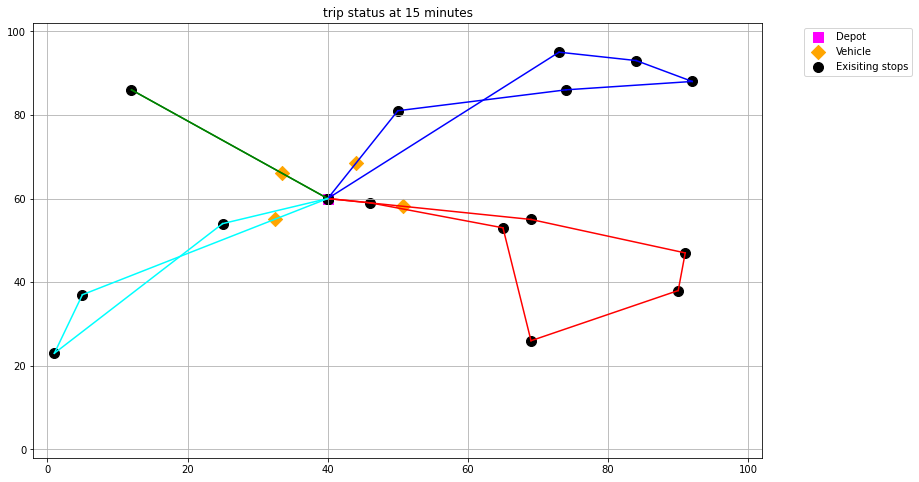

soln-at-time-020.png
0 red [1, 11, 12, 17, 8, 9, 6, 0]
1 blue [2, 14, 18, 15, 19, 7, 0]
2 green [3, 10, 0]
3 cyan [4, 16, 13, 5, 0]


<Figure size 432x288 with 0 Axes>

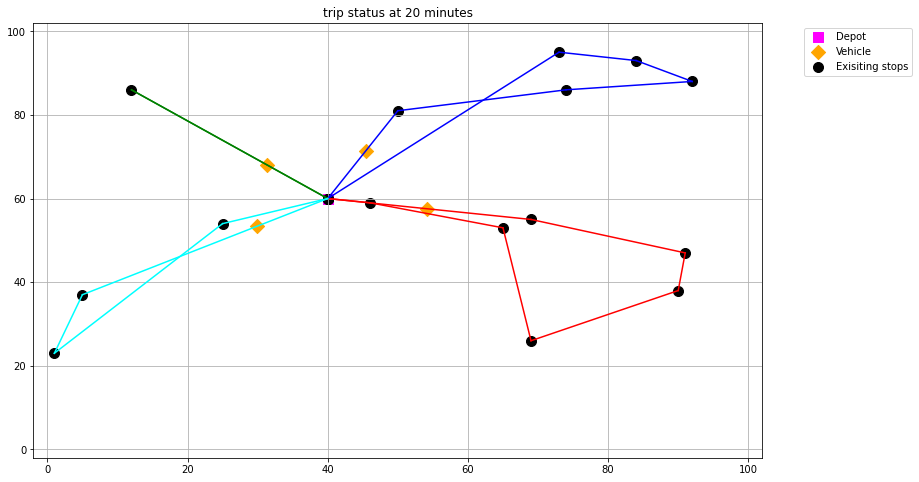

soln-at-time-025.png
0 red [1, 11, 12, 17, 8, 9, 6, 0]
1 blue [2, 14, 18, 15, 19, 7, 0]
2 green [3, 10, 0]
3 cyan [4, 16, 13, 5, 0]


<Figure size 432x288 with 0 Axes>

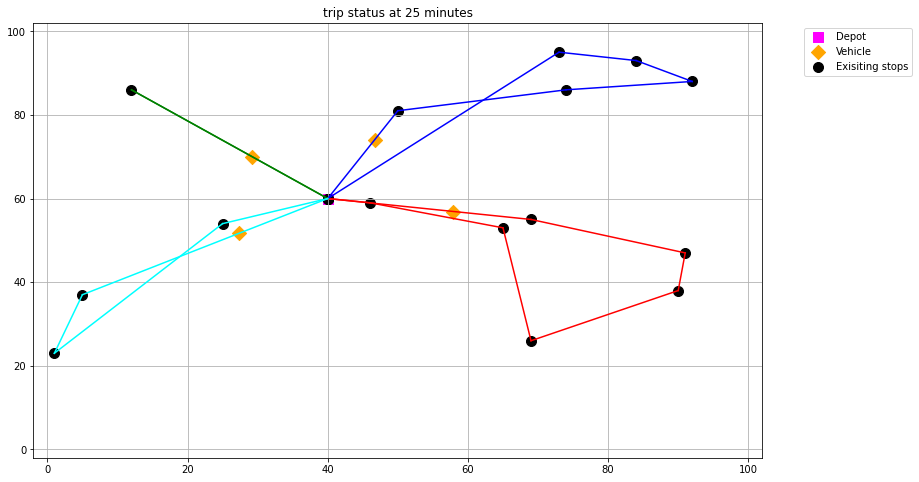

soln-at-time-030.png
0 red [1, 11, 12, 17, 8, 9, 6, 0]
1 blue [2, 14, 18, 15, 19, 7, 0]
2 green [3, 10, 0]
3 cyan [4, 16, 13, 5, 0]


<Figure size 432x288 with 0 Axes>

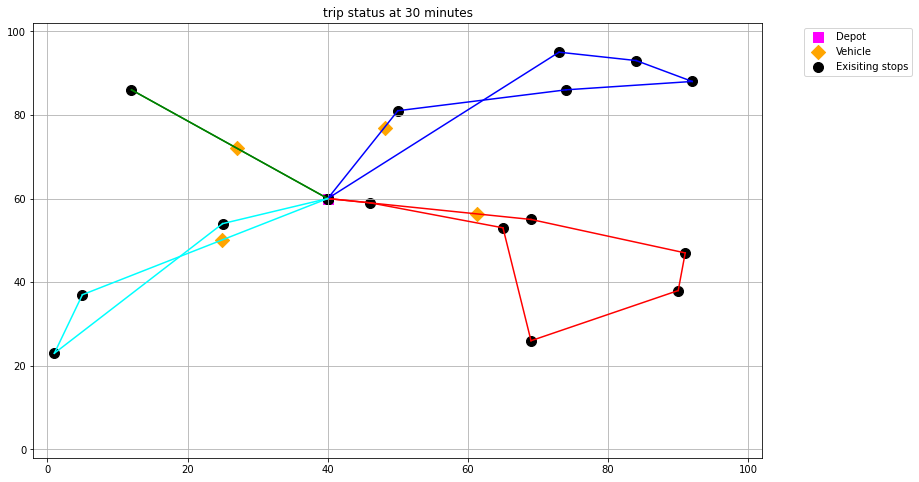

soln-at-time-035.png
0 red [1, 11, 12, 17, 8, 9, 6, 0]
1 blue [2, 14, 18, 15, 19, 7, 0]
2 green [3, 10, 0]
3 cyan [4, 16, 13, 5, 0]


<Figure size 432x288 with 0 Axes>

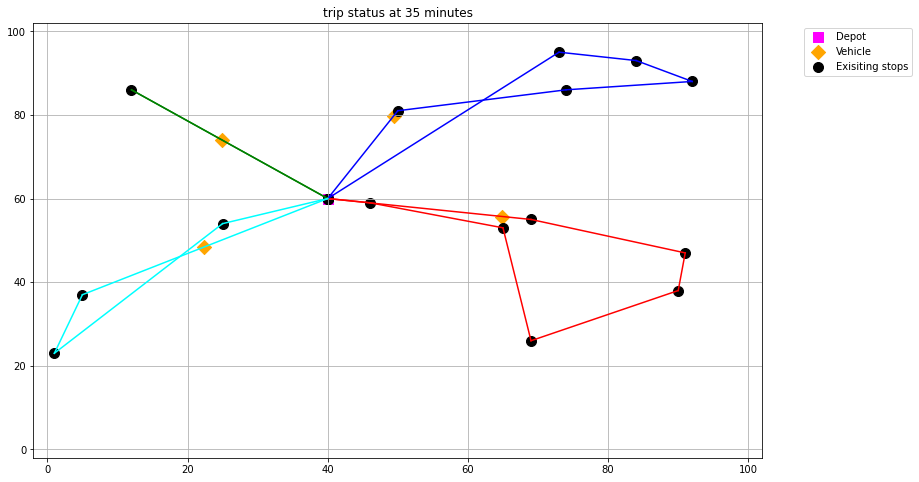

soln-at-time-040.png
0 red [1, 11, 12, 17, 8, 9, 6, 0]
1 blue [2, 14, 18, 15, 19, 7, 0]
2 green [3, 10, 0]
3 cyan [4, 16, 13, 5, 0]


<Figure size 432x288 with 0 Axes>

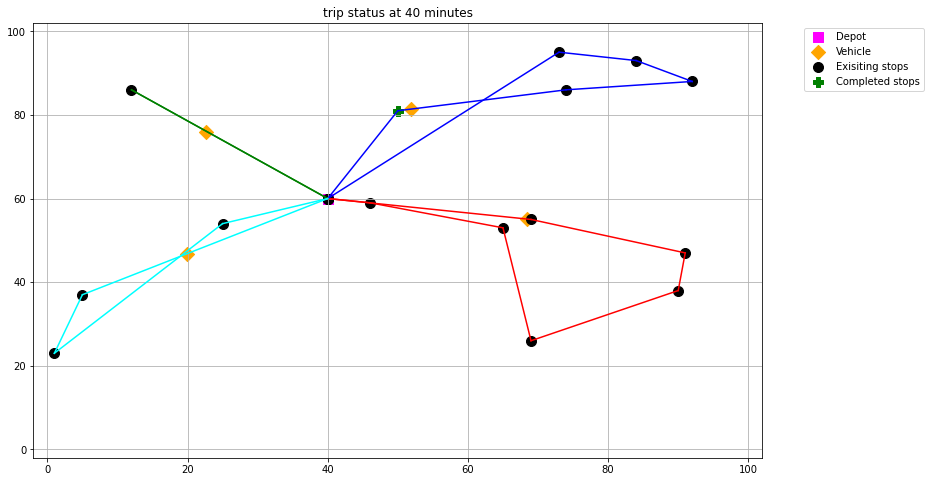

soln-at-time-045.png
0 red [1, 11, 12, 17, 8, 9, 6, 0]
1 blue [2, 14, 18, 15, 19, 7, 0]
2 green [3, 10, 0]
3 cyan [4, 16, 13, 5, 0]


<Figure size 432x288 with 0 Axes>

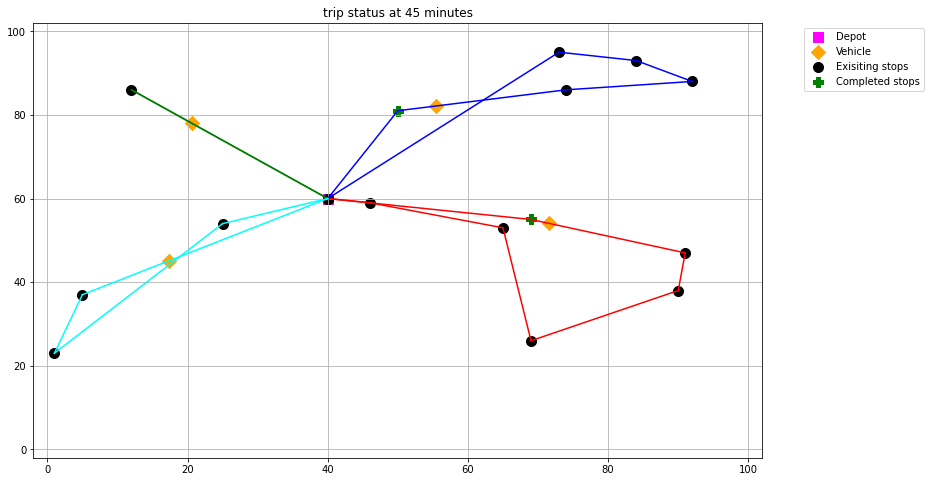

soln-at-time-050.png
0 red [1, 11, 12, 17, 8, 9, 6, 0]
1 blue [2, 14, 18, 15, 19, 7, 0]
2 green [3, 10, 0]
3 cyan [4, 16, 13, 5, 0]


<Figure size 432x288 with 0 Axes>

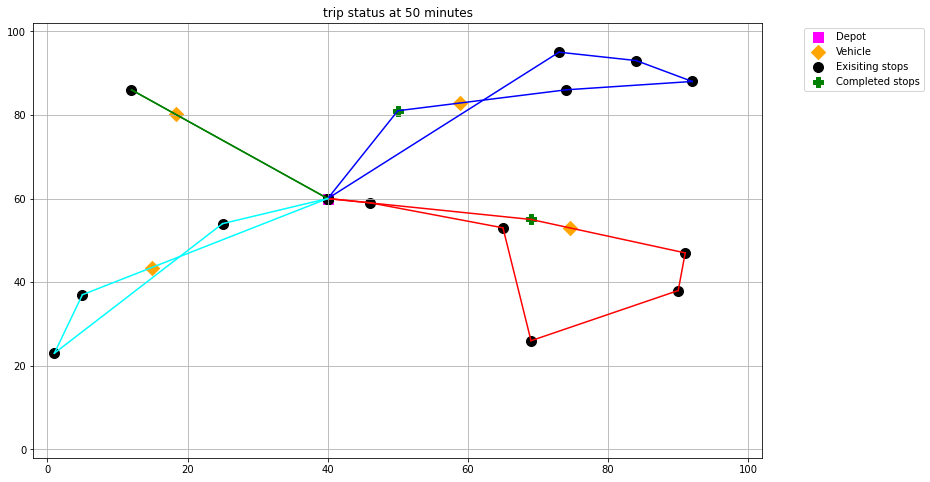

soln-at-time-055.png
0 red [1, 11, 12, 17, 8, 9, 6, 0]
1 blue [2, 14, 18, 15, 19, 7, 0]
2 green [3, 10, 0]
3 cyan [4, 16, 13, 5, 0]


<Figure size 432x288 with 0 Axes>

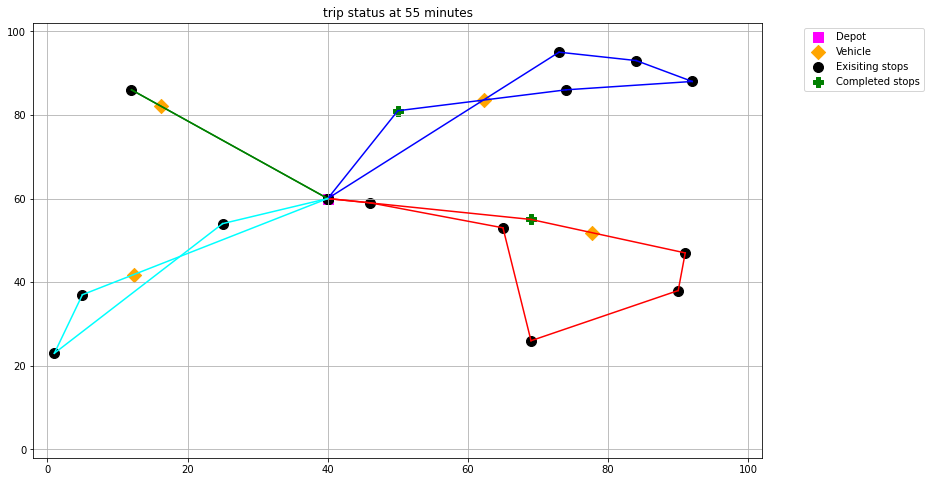

soln-at-time-060.png
0 red [1, 11, 12, 17, 8, 9, 6, 0]
1 blue [2, 14, 18, 15, 19, 7, 0]
2 green [3, 10, 0]
3 cyan [4, 16, 13, 5, 0]


<Figure size 432x288 with 0 Axes>

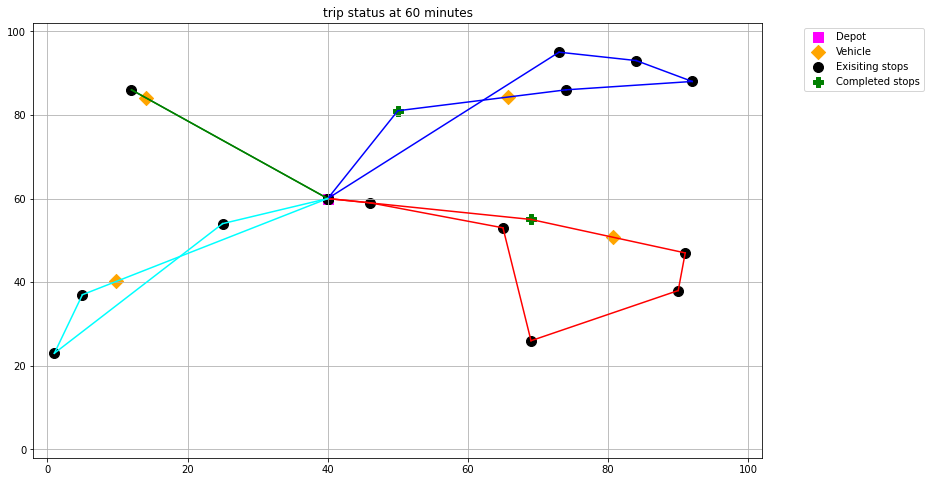

()

<Figure size 432x288 with 0 Axes>

In [19]:
plot5minints(crl2, points, distmat, 0, 1, 0, 50)

for i in range(10):
    filename = 'image_'+str(i).zfill(2) + '.png'
    print (filename)
    pc, vp = tottripstatus(crl2, (i+1)*0.3, 50)
    plottripstatus(crl2, pc, vp, filename)

In [20]:
def newsolution(points, points_covered, origin, vehicle_position, t=1):
    'function to repeatedly call the vehicle routing problem'
       
        
    # Get list of new points
    print (len(points), len(points_covered))
    points, covlist = modifypoints(points, points_covered, origin, vehicle_position)    
    #print (newp)
    ##print ("\n")
    #print (covlist)
    #print (len(points), len(covlist), len(newp))
    
    #Add new points
    print (len(points))
    points, newadd = genpoints(points, 5)
    npoints = len(points)
    print (len(points))
    ptitle = 'stops at t=' + str(t*60) + 'minutes'
    plotpoints(points, newadd, 'test.png', covlist, ptitle)
    
    #get the new distmat
    distmat = gendistmat(points)
    print (distmat.shape)
    
    #get the new solution
    data2, manager2, routing2, solution2 = main_v2d(distmat)
    
    # clean up the points
    rl2 = return_solution(data2, manager2, routing2, solution2)
    crl2 = cleanpoints_v2p(rl2, npoints)
    print (crl2)
    
    plotroutes(points, crl2, 'test_routes.png')
    
    pc, vp = tottripstatus(crl2, points, distmat, 1, 50)
    plottripstatus(crl2, points, pc, vp, 'twohours.png')

20 2
18
23
(23, 23)
Route for vehicle 0:
 1 ->  11 ->  15 ->  18 ->  22 ->  8 ->  9 ->  19 -> 0
Distance of the route: 138m

Route for vehicle 1:
 2 ->  7 ->  17 ->  13 ->  16 ->  6 -> 0
Distance of the route: 126m

Route for vehicle 2:
 3 ->  10 ->  20 -> 0
Distance of the route: 142m

Route for vehicle 3:
 4 ->  12 ->  14 ->  5 ->  21 -> 0
Distance of the route: 102m

Maximum of the route distances: 142m
[[1, 11, 15, 18, 22, 8, 9, 19, 0], [2, 7, 17, 13, 16, 6, 0], [3, 10, 20, 0], [4, 12, 14, 5, 21, 0]]
0 red [1, 11, 15, 18, 22, 8, 9, 19, 0]
1 blue [2, 7, 17, 13, 16, 6, 0]
2 green [3, 10, 20, 0]
3 cyan [4, 12, 14, 5, 21, 0]


<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

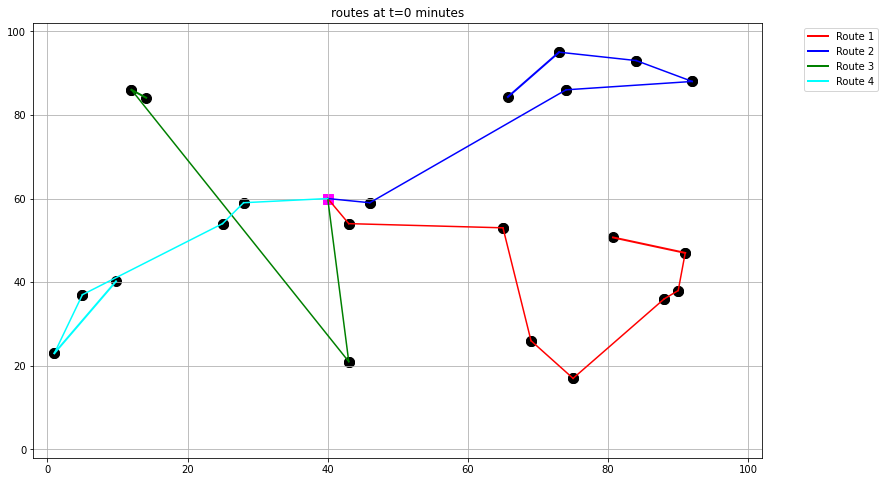

0 red [1, 11, 15, 18, 22, 8, 9, 19, 0]
1 blue [2, 7, 17, 13, 16, 6, 0]
2 green [3, 10, 20, 0]
3 cyan [4, 12, 14, 5, 21, 0]


<Figure size 432x288 with 0 Axes>

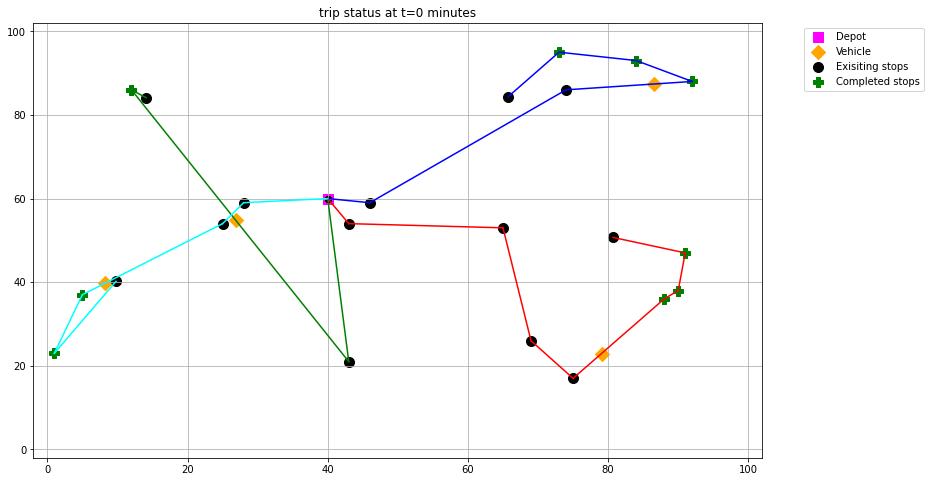

<Figure size 432x288 with 0 Axes>

In [21]:
newsolution(points, pc, origin, vp, t=1)

In [22]:
def loopover(ncycles=5):
    '''
    setting up to loop over time 
    '''
    
    
    numpoints = 15
    numvehicles = 4
    origin = (40,60)
    speed = 50
    vehpos = numvehicles * [origin]
    print ('vehicle positions are', vehpos)

    points = initpoints(origin, vehpos)
    points, newadd = genpoints(points, numpoints)
    distmat = gendistmat(points)
    npoints = len(points)
    print (npoints)
    ptitle = 'stops at t=0 minutes'
    plotpoints(points, newadd, 'points_0.png')
        
        
    # loop
    counter = 0
    while (counter < ncycles):
        counter += 1
        
        # solver the problem
        data2, manager2, routing2, solution2 = main_v2d(distmat)
        
        # get the routes
        routefilename = 'route_'+str(counter) + '.png'
        rtitle = 'route at t=' + str((counter-1)*60) + ' minutes'
        rl2 = return_solution(data2, manager2, routing2, solution2)
        crl2 = cleanpoints_v2p(rl2, npoints)
        plotroutes(points, crl2, routefilename, title = rtitle)
        
        #computer situation in steps of 5 for 1 hour
        plot5minints(crl2, points, distmat, 0, 1, counter-1, speed)
        
        # compute new points covered
        filename = 'time_' + str(counter) + '.png'    
        tstitle = 'trip status at t=' + str(counter*60) + ' minutes'
        points_covered, vehicle_position = tottripstatus(crl2, points, distmat, 1, 50)
        plottripstatus(crl2, points, points_covered, vehicle_position, filename, title=tstitle)        
        
        old_points = points.copy()
                
        # modify points
        points, covlist = modifypoints(points, points_covered, origin, vehicle_position)    
        
        #add new points
        pointfilename = 'points_' + str(counter) + '.png'
        points, newadd = genpoints(points, 5)    
        npoints = len(points)
        print (len(points))
        ptitle = 'stops at t=' + str(counter *60) + ' minutes'
        plotpoints(points, newadd, pointfilename, covlist, title = ptitle)
        
        ptfname = 'routewithpoints_' + str(counter) + '.png'
        ntitle = 'route and new stops at t=' + str(counter *60) + 'minutes'
        plottripwithnewpoints(crl2, old_points, points_covered, vehicle_position, newadd, 
                              ptfname, title=ntitle)

        distmat = gendistmat(points)
        print (distmat.shape)

vehicle positions are [(40, 60), (40, 60), (40, 60), (40, 60)]
origin and vehicle positions are [(40, 60), (40, 60), (40, 60), (40, 60), (40, 60)]
20
Route for vehicle 0:
 1 ->  9 ->  19 ->  5 ->  17 ->  13 -> 0
Distance of the route: 188m

Route for vehicle 1:
 2 ->  14 ->  8 ->  11 ->  18 ->  6 ->  12 -> 0
Distance of the route: 148m

Route for vehicle 2:
 3 ->  16 ->  7 -> 0
Distance of the route: 194m

Route for vehicle 3:
 4 ->  10 ->  15 -> 0
Distance of the route: 98m

Maximum of the route distances: 194m
0 red [1, 9, 19, 5, 17, 13, 0]
1 blue [2, 14, 8, 11, 18, 6, 12, 0]
2 green [3, 16, 7, 0]
3 cyan [4, 10, 15, 0]


<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

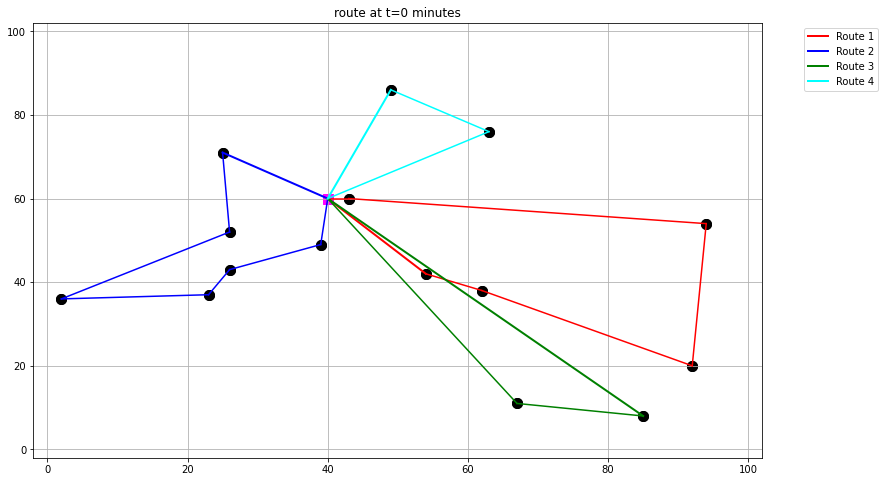

soln-at-time-005.png
0 red [1, 9, 19, 5, 17, 13, 0]
1 blue [2, 14, 8, 11, 18, 6, 12, 0]
2 green [3, 16, 7, 0]
3 cyan [4, 10, 15, 0]


<Figure size 432x288 with 0 Axes>

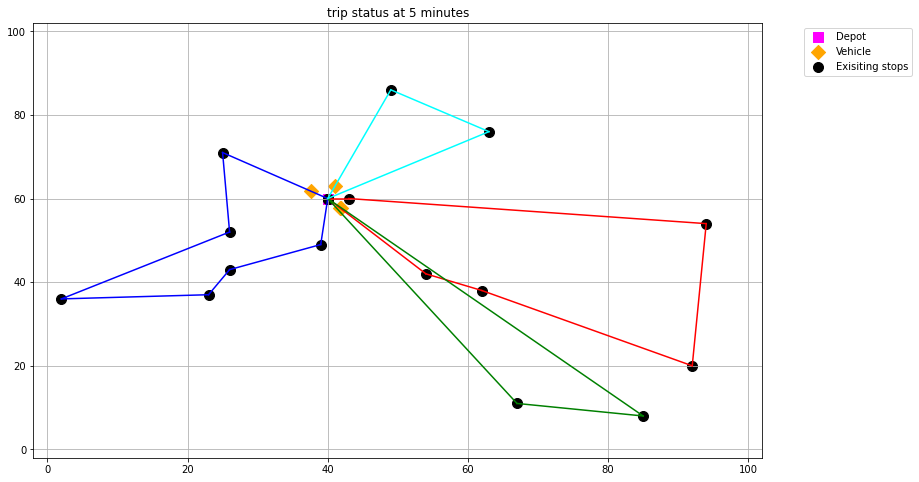

soln-at-time-010.png
0 red [1, 9, 19, 5, 17, 13, 0]
1 blue [2, 14, 8, 11, 18, 6, 12, 0]
2 green [3, 16, 7, 0]
3 cyan [4, 10, 15, 0]


<Figure size 432x288 with 0 Axes>

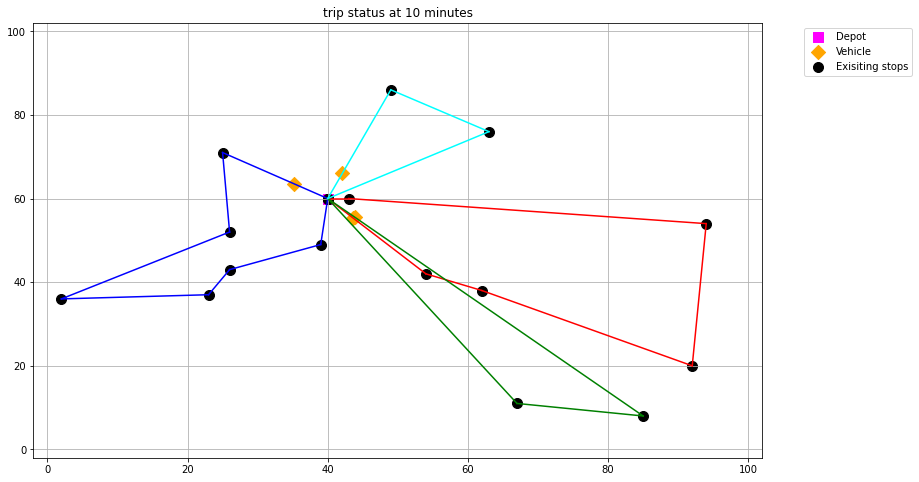

soln-at-time-015.png
0 red [1, 9, 19, 5, 17, 13, 0]
1 blue [2, 14, 8, 11, 18, 6, 12, 0]
2 green [3, 16, 7, 0]
3 cyan [4, 10, 15, 0]


<Figure size 432x288 with 0 Axes>

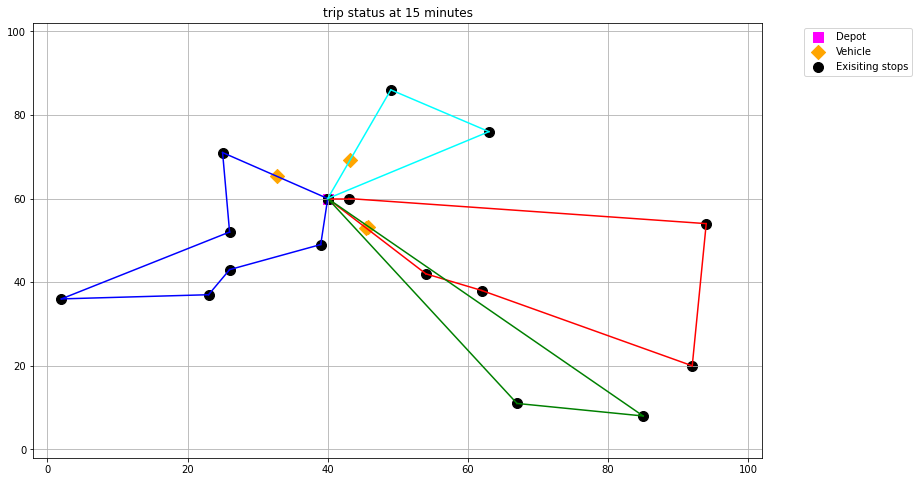

soln-at-time-020.png
0 red [1, 9, 19, 5, 17, 13, 0]
1 blue [2, 14, 8, 11, 18, 6, 12, 0]
2 green [3, 16, 7, 0]
3 cyan [4, 10, 15, 0]


<Figure size 432x288 with 0 Axes>

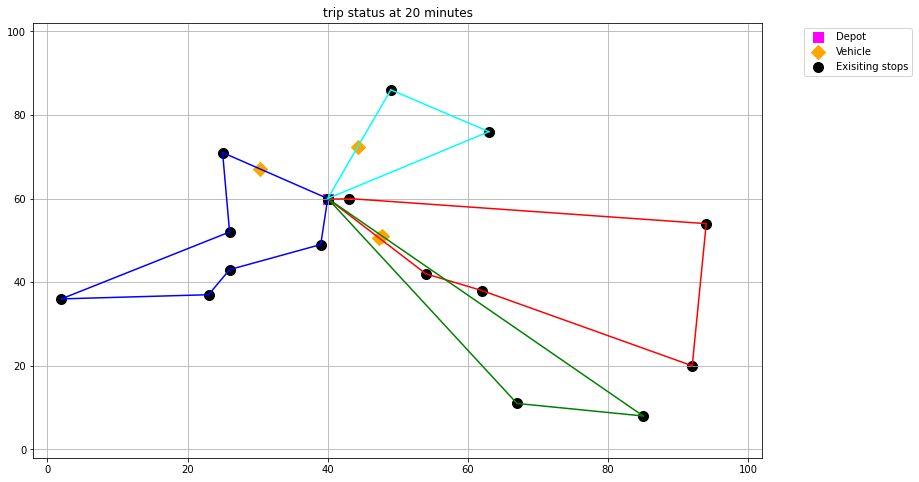

soln-at-time-025.png
0 red [1, 9, 19, 5, 17, 13, 0]
1 blue [2, 14, 8, 11, 18, 6, 12, 0]
2 green [3, 16, 7, 0]
3 cyan [4, 10, 15, 0]


<Figure size 432x288 with 0 Axes>

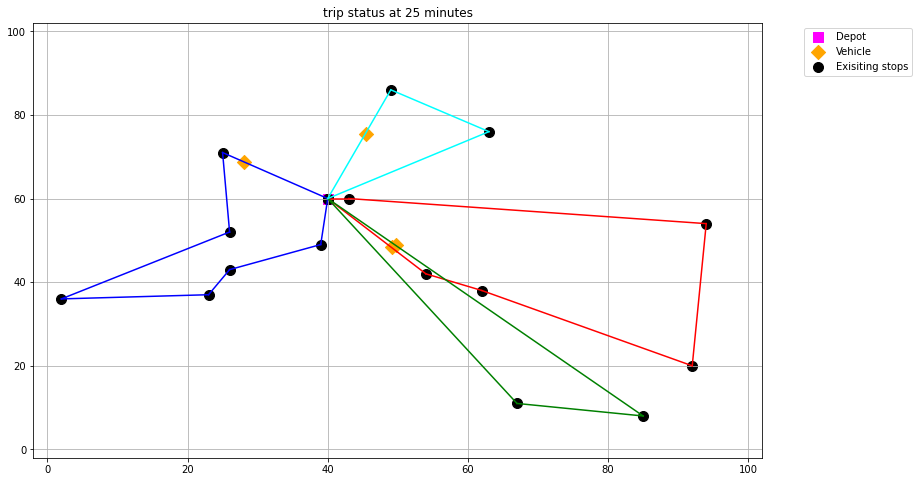

soln-at-time-030.png
0 red [1, 9, 19, 5, 17, 13, 0]
1 blue [2, 14, 8, 11, 18, 6, 12, 0]
2 green [3, 16, 7, 0]
3 cyan [4, 10, 15, 0]


<Figure size 432x288 with 0 Axes>

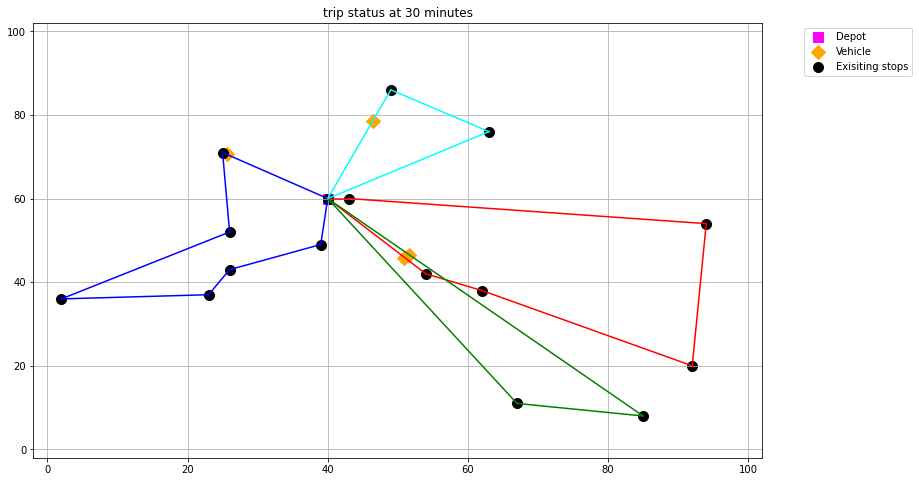

soln-at-time-035.png
0 red [1, 9, 19, 5, 17, 13, 0]
1 blue [2, 14, 8, 11, 18, 6, 12, 0]
2 green [3, 16, 7, 0]
3 cyan [4, 10, 15, 0]


<Figure size 432x288 with 0 Axes>

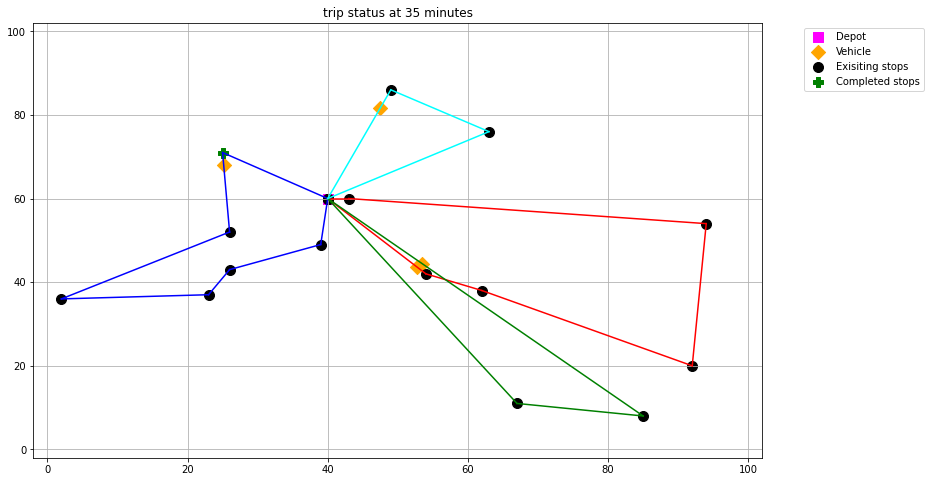

soln-at-time-040.png
0 red [1, 9, 19, 5, 17, 13, 0]
1 blue [2, 14, 8, 11, 18, 6, 12, 0]
2 green [3, 16, 7, 0]
3 cyan [4, 10, 15, 0]


<Figure size 432x288 with 0 Axes>

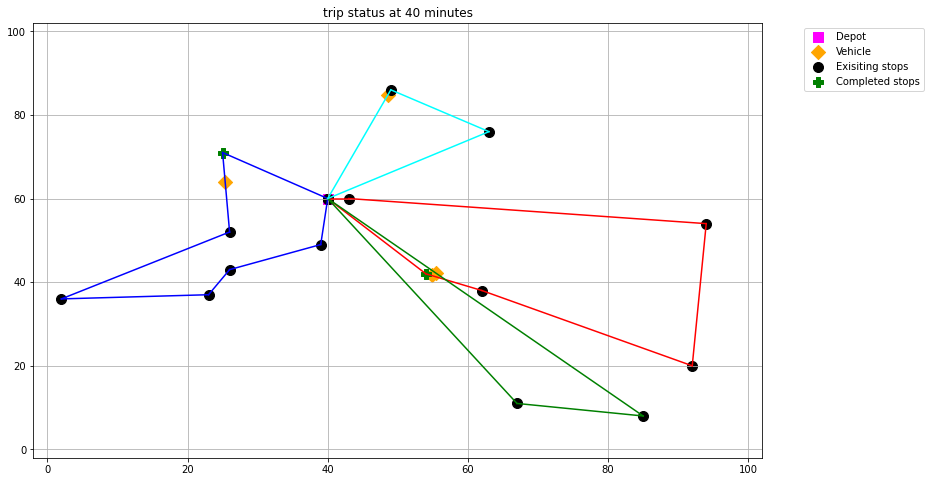

soln-at-time-045.png
0 red [1, 9, 19, 5, 17, 13, 0]
1 blue [2, 14, 8, 11, 18, 6, 12, 0]
2 green [3, 16, 7, 0]
3 cyan [4, 10, 15, 0]


<Figure size 432x288 with 0 Axes>

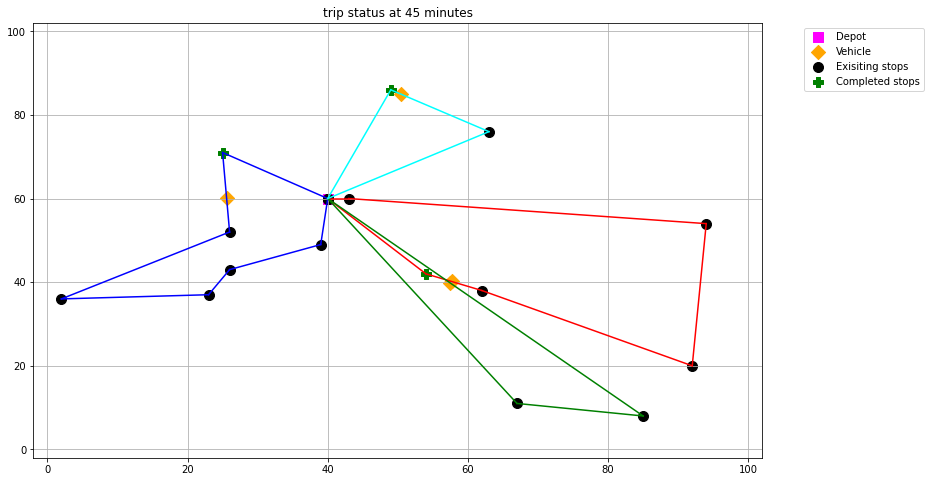

soln-at-time-050.png
0 red [1, 9, 19, 5, 17, 13, 0]
1 blue [2, 14, 8, 11, 18, 6, 12, 0]
2 green [3, 16, 7, 0]
3 cyan [4, 10, 15, 0]


<Figure size 432x288 with 0 Axes>

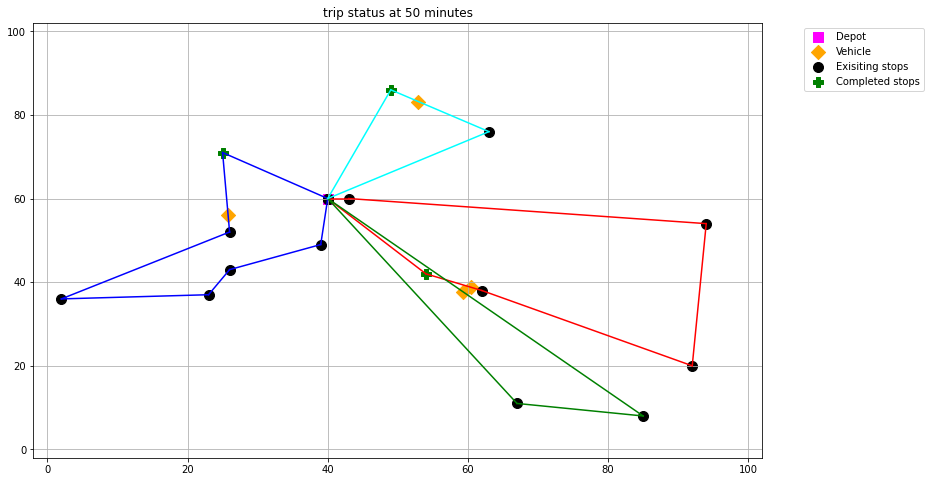

soln-at-time-055.png
0 red [1, 9, 19, 5, 17, 13, 0]
1 blue [2, 14, 8, 11, 18, 6, 12, 0]
2 green [3, 16, 7, 0]
3 cyan [4, 10, 15, 0]


<Figure size 432x288 with 0 Axes>

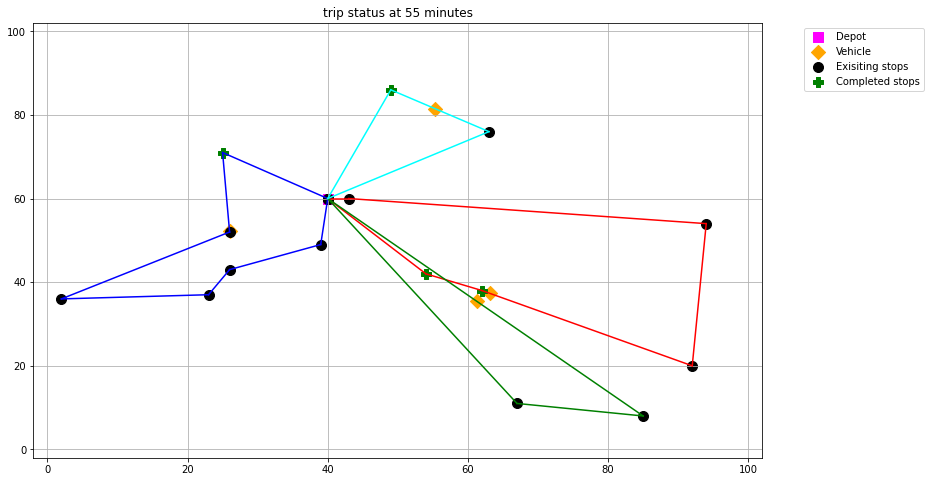

soln-at-time-060.png
0 red [1, 9, 19, 5, 17, 13, 0]
1 blue [2, 14, 8, 11, 18, 6, 12, 0]
2 green [3, 16, 7, 0]
3 cyan [4, 10, 15, 0]


<Figure size 432x288 with 0 Axes>

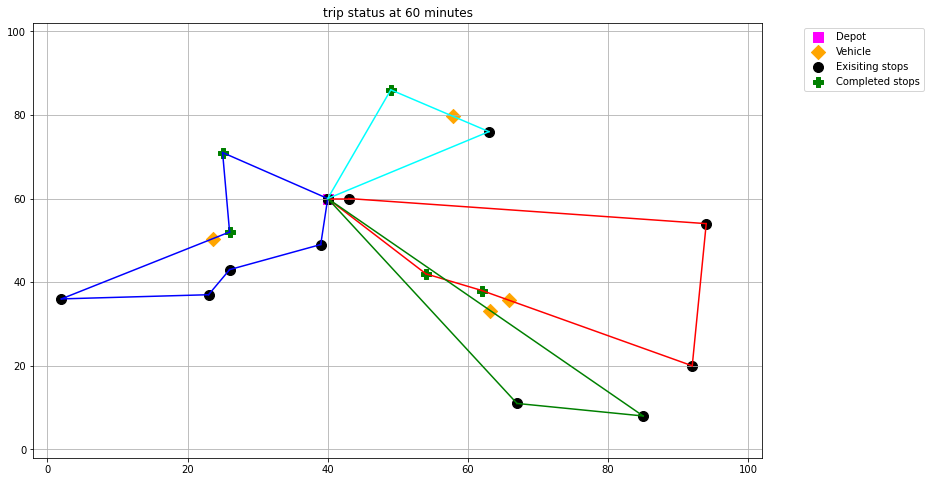

0 red [1, 9, 19, 5, 17, 13, 0]
1 blue [2, 14, 8, 11, 18, 6, 12, 0]
2 green [3, 16, 7, 0]
3 cyan [4, 10, 15, 0]


<Figure size 432x288 with 0 Axes>

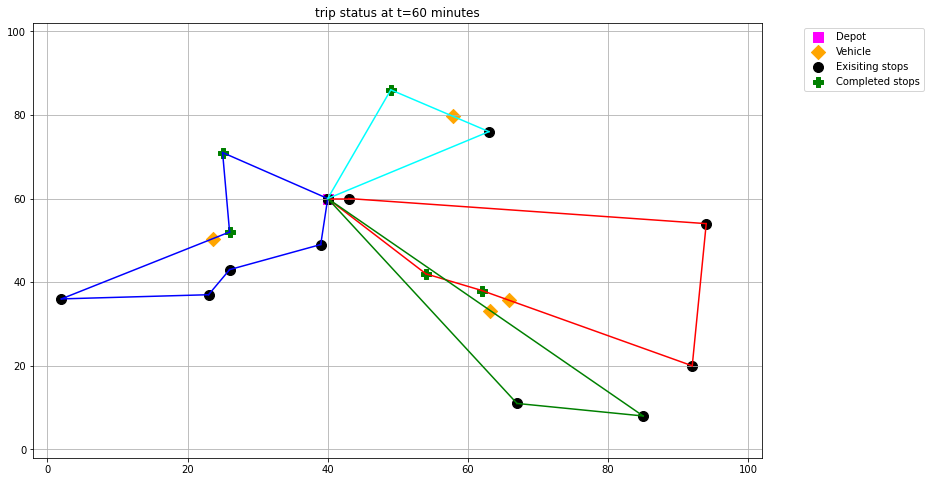

20
0 red [1, 9, 19, 5, 17, 13, 0]
1 blue [2, 14, 8, 11, 18, 6, 12, 0]
2 green [3, 16, 7, 0]
3 cyan [4, 10, 15, 0]


<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

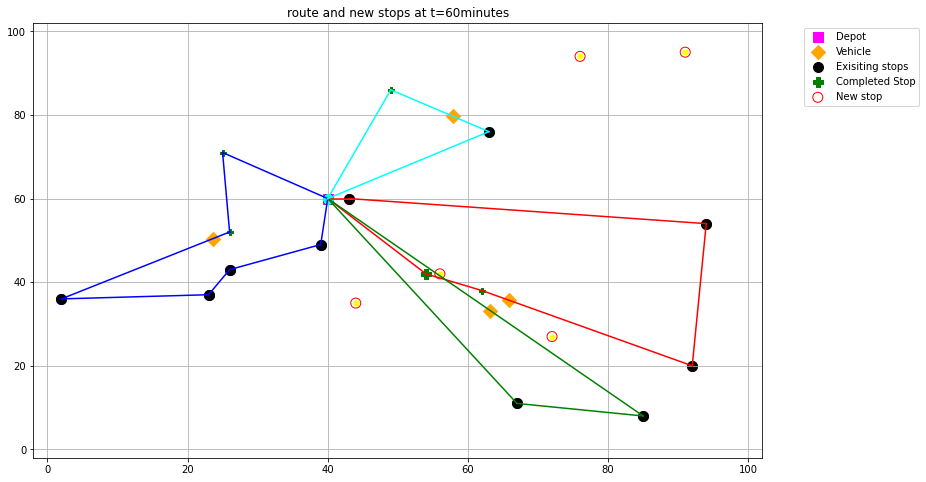

(20, 20)
Route for vehicle 0:
 1 ->  7 ->  12 ->  5 ->  15 ->  17 ->  10 -> 0
Distance of the route: 158m

Route for vehicle 1:
 2 ->  14 ->  8 ->  6 ->  9 -> 0
Distance of the route: 98m

Route for vehicle 2:
 3 ->  16 ->  13 -> 0
Distance of the route: 126m

Route for vehicle 3:
 4 ->  19 ->  18 ->  11 -> 0
Distance of the route: 134m

Maximum of the route distances: 158m
0 red [1, 7, 12, 5, 15, 17, 10, 0]
1 blue [2, 14, 8, 6, 9, 0]
2 green [3, 16, 13, 0]
3 cyan [4, 19, 18, 11, 0]


<Figure size 432x288 with 0 Axes>

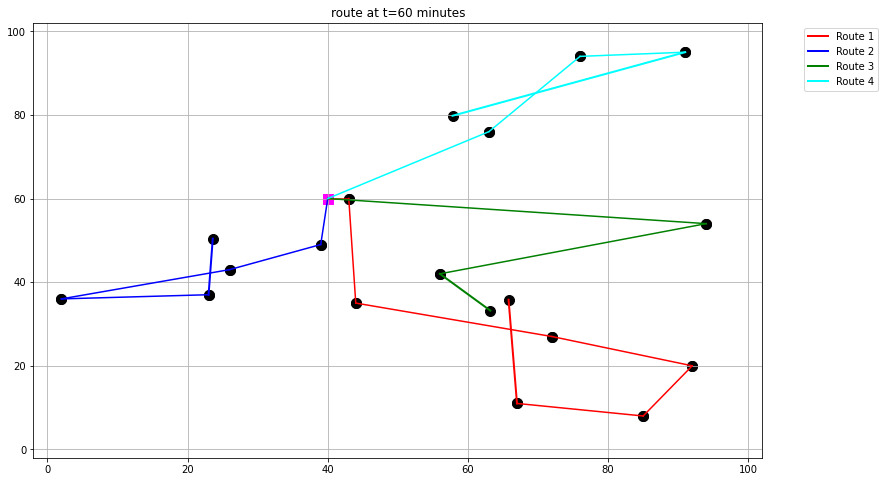

soln-at-time-065.png
0 red [1, 7, 12, 5, 15, 17, 10, 0]
1 blue [2, 14, 8, 6, 9, 0]
2 green [3, 16, 13, 0]
3 cyan [4, 19, 18, 11, 0]


<Figure size 432x288 with 0 Axes>

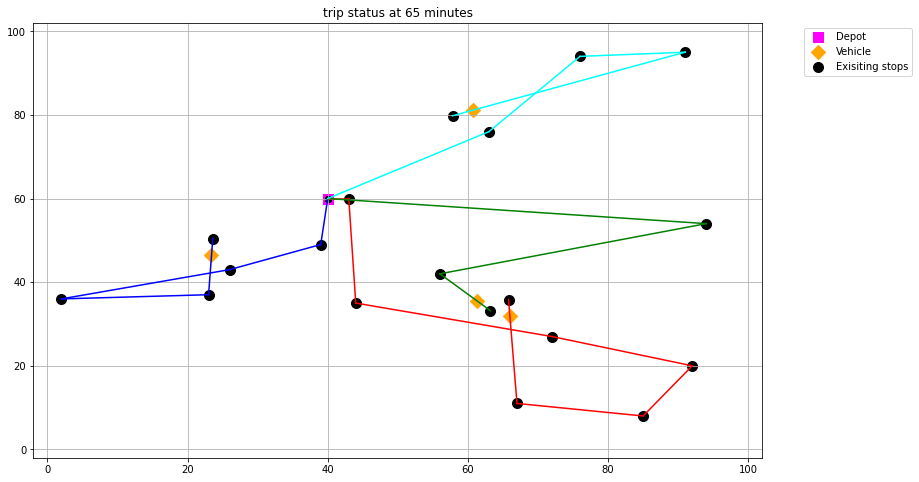

soln-at-time-070.png
0 red [1, 7, 12, 5, 15, 17, 10, 0]
1 blue [2, 14, 8, 6, 9, 0]
2 green [3, 16, 13, 0]
3 cyan [4, 19, 18, 11, 0]


<Figure size 432x288 with 0 Axes>

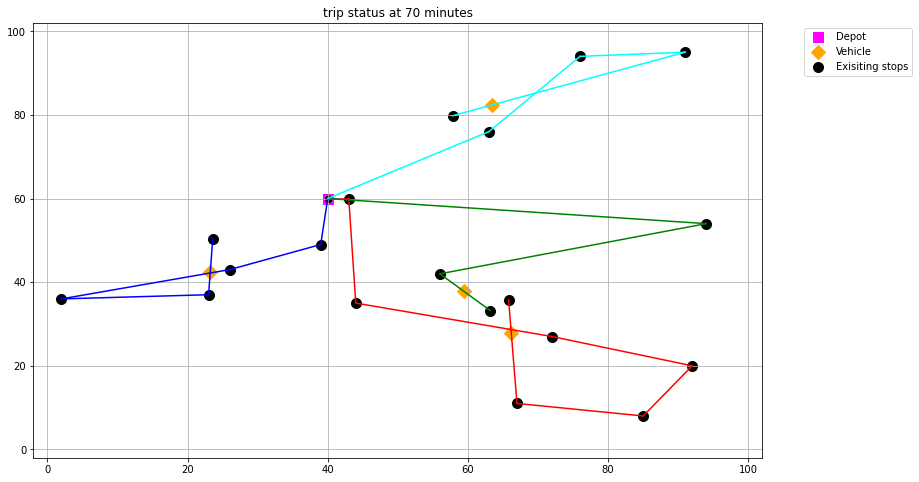

soln-at-time-075.png
0 red [1, 7, 12, 5, 15, 17, 10, 0]
1 blue [2, 14, 8, 6, 9, 0]
2 green [3, 16, 13, 0]
3 cyan [4, 19, 18, 11, 0]


<Figure size 432x288 with 0 Axes>

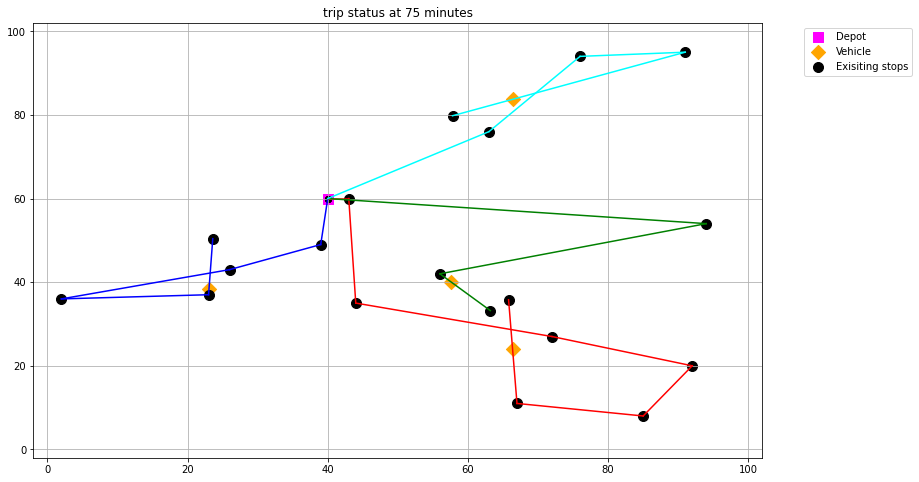

soln-at-time-080.png
0 red [1, 7, 12, 5, 15, 17, 10, 0]
1 blue [2, 14, 8, 6, 9, 0]
2 green [3, 16, 13, 0]
3 cyan [4, 19, 18, 11, 0]


<Figure size 432x288 with 0 Axes>

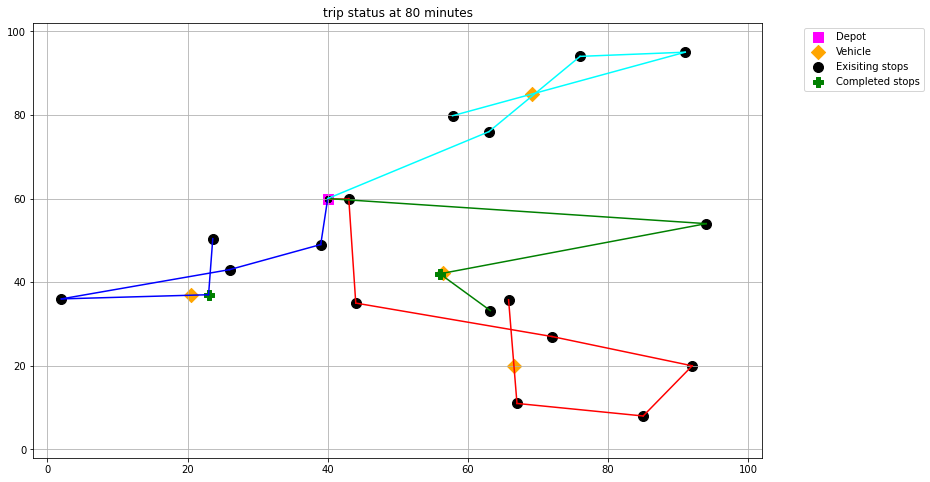

soln-at-time-085.png
0 red [1, 7, 12, 5, 15, 17, 10, 0]
1 blue [2, 14, 8, 6, 9, 0]
2 green [3, 16, 13, 0]
3 cyan [4, 19, 18, 11, 0]


<Figure size 432x288 with 0 Axes>

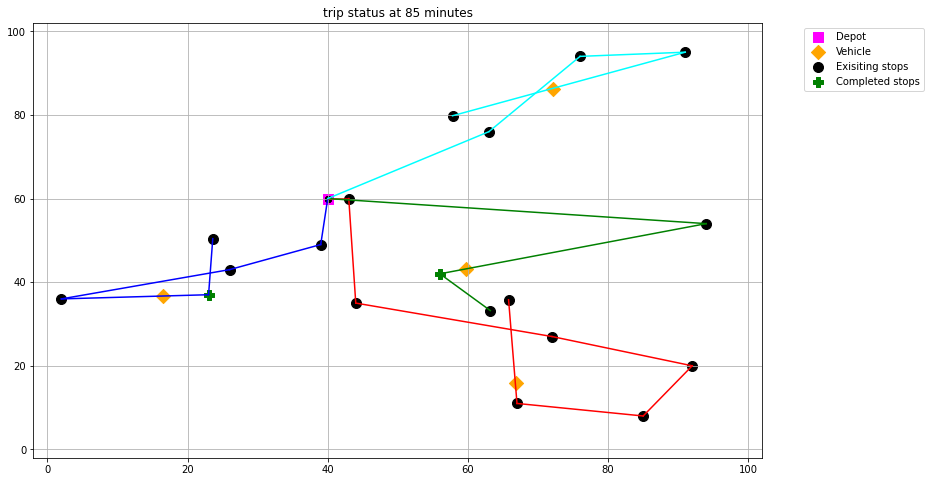

soln-at-time-090.png
0 red [1, 7, 12, 5, 15, 17, 10, 0]
1 blue [2, 14, 8, 6, 9, 0]
2 green [3, 16, 13, 0]
3 cyan [4, 19, 18, 11, 0]


<Figure size 432x288 with 0 Axes>

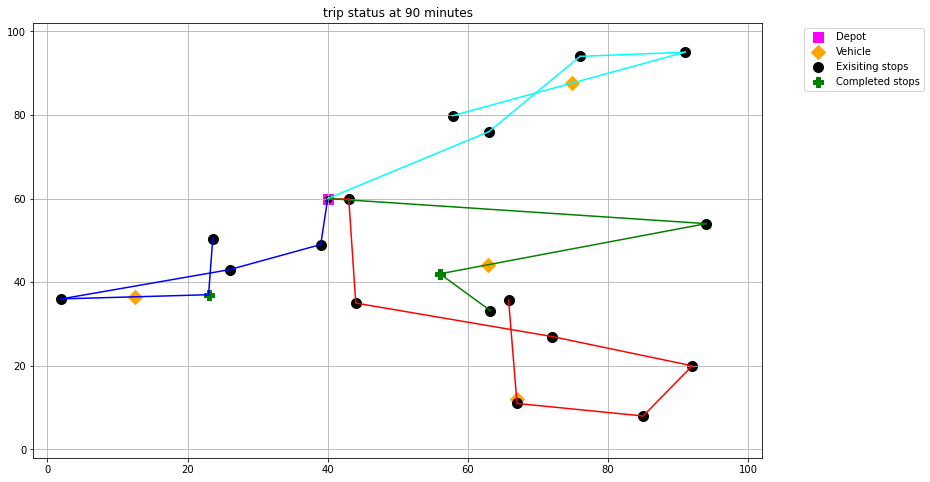

soln-at-time-095.png
0 red [1, 7, 12, 5, 15, 17, 10, 0]
1 blue [2, 14, 8, 6, 9, 0]
2 green [3, 16, 13, 0]
3 cyan [4, 19, 18, 11, 0]


<Figure size 432x288 with 0 Axes>

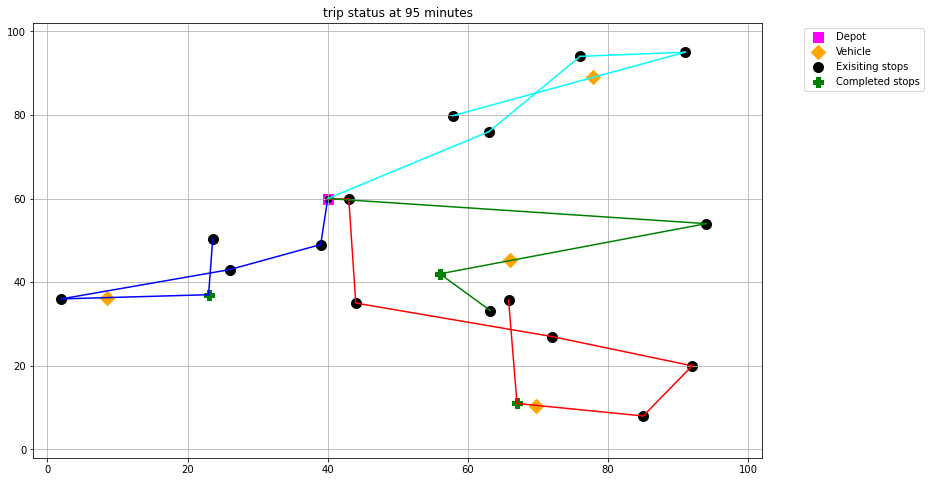

soln-at-time-100.png
0 red [1, 7, 12, 5, 15, 17, 10, 0]
1 blue [2, 14, 8, 6, 9, 0]
2 green [3, 16, 13, 0]
3 cyan [4, 19, 18, 11, 0]


<Figure size 432x288 with 0 Axes>

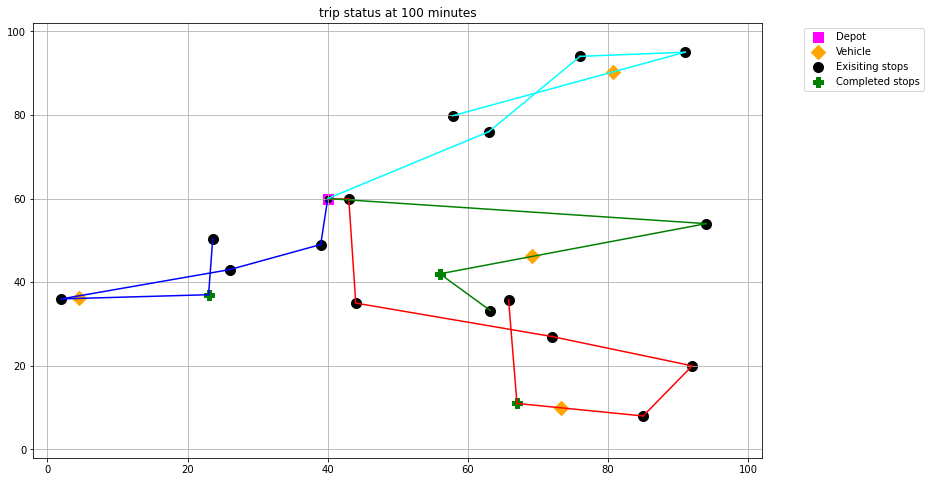

soln-at-time-105.png
0 red [1, 7, 12, 5, 15, 17, 10, 0]
1 blue [2, 14, 8, 6, 9, 0]
2 green [3, 16, 13, 0]
3 cyan [4, 19, 18, 11, 0]


<Figure size 432x288 with 0 Axes>

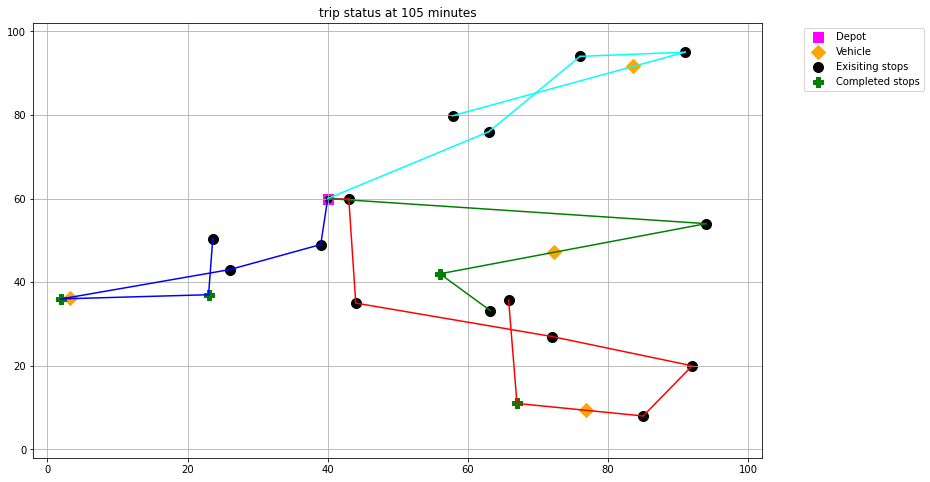

soln-at-time-110.png
0 red [1, 7, 12, 5, 15, 17, 10, 0]
1 blue [2, 14, 8, 6, 9, 0]
2 green [3, 16, 13, 0]
3 cyan [4, 19, 18, 11, 0]


<Figure size 432x288 with 0 Axes>

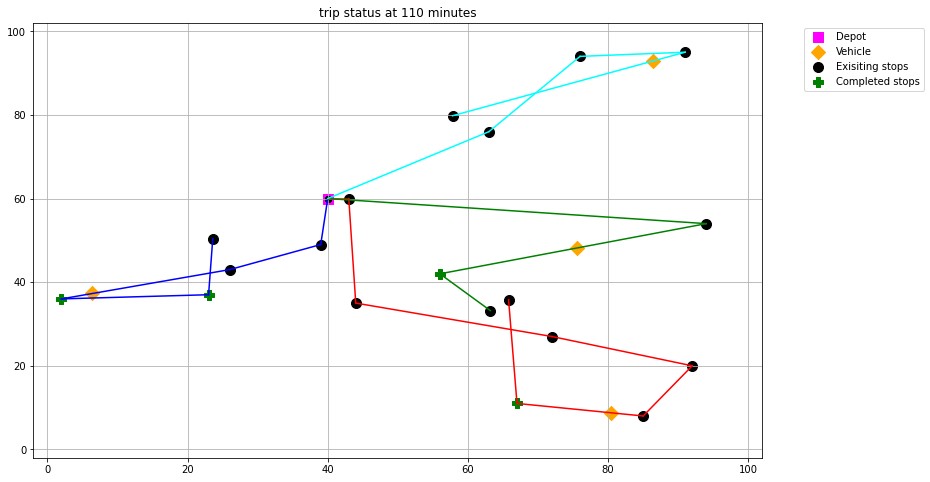

soln-at-time-115.png
0 red [1, 7, 12, 5, 15, 17, 10, 0]
1 blue [2, 14, 8, 6, 9, 0]
2 green [3, 16, 13, 0]
3 cyan [4, 19, 18, 11, 0]


<Figure size 432x288 with 0 Axes>

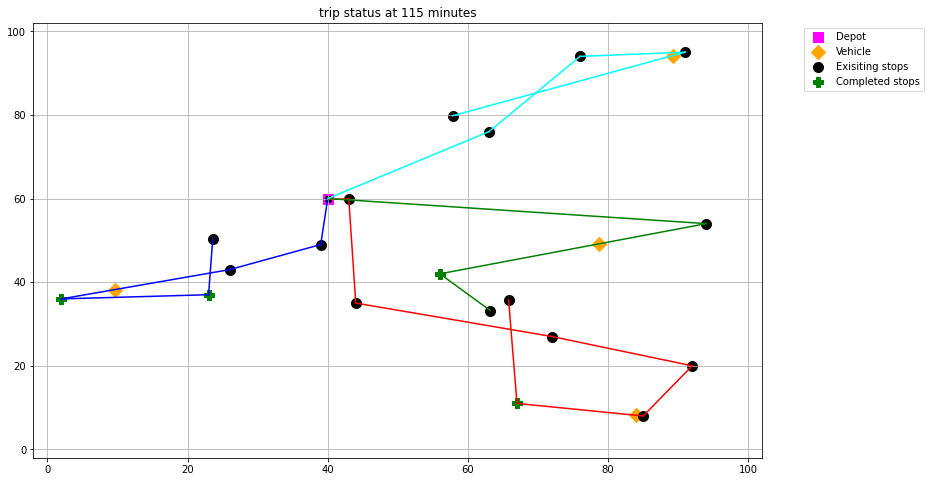

soln-at-time-120.png
0 red [1, 7, 12, 5, 15, 17, 10, 0]
1 blue [2, 14, 8, 6, 9, 0]
2 green [3, 16, 13, 0]
3 cyan [4, 19, 18, 11, 0]


<Figure size 432x288 with 0 Axes>

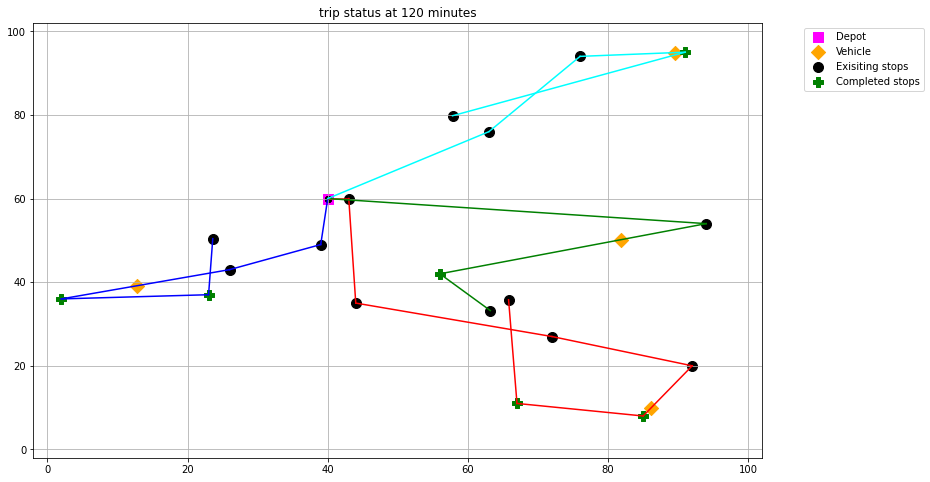

0 red [1, 7, 12, 5, 15, 17, 10, 0]
1 blue [2, 14, 8, 6, 9, 0]
2 green [3, 16, 13, 0]
3 cyan [4, 19, 18, 11, 0]


<Figure size 432x288 with 0 Axes>

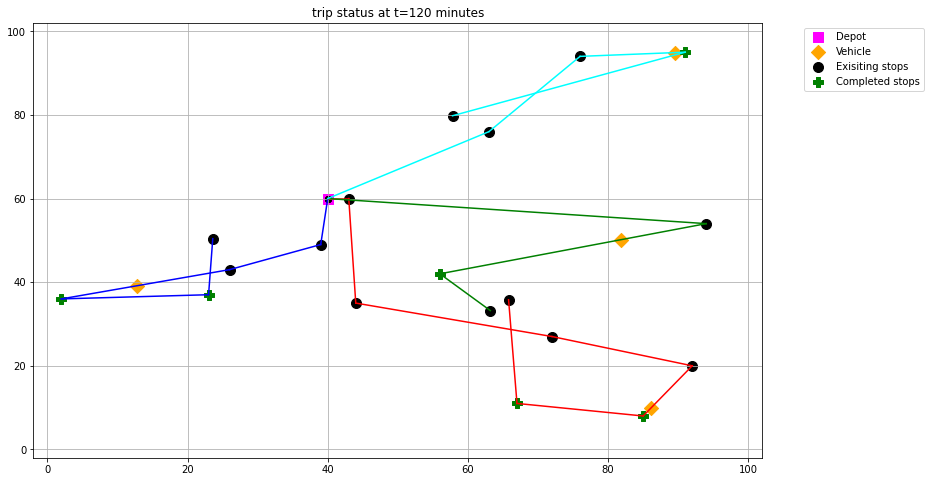

19
0 red [1, 7, 12, 5, 15, 17, 10, 0]
1 blue [2, 14, 8, 6, 9, 0]
2 green [3, 16, 13, 0]
3 cyan [4, 19, 18, 11, 0]


<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

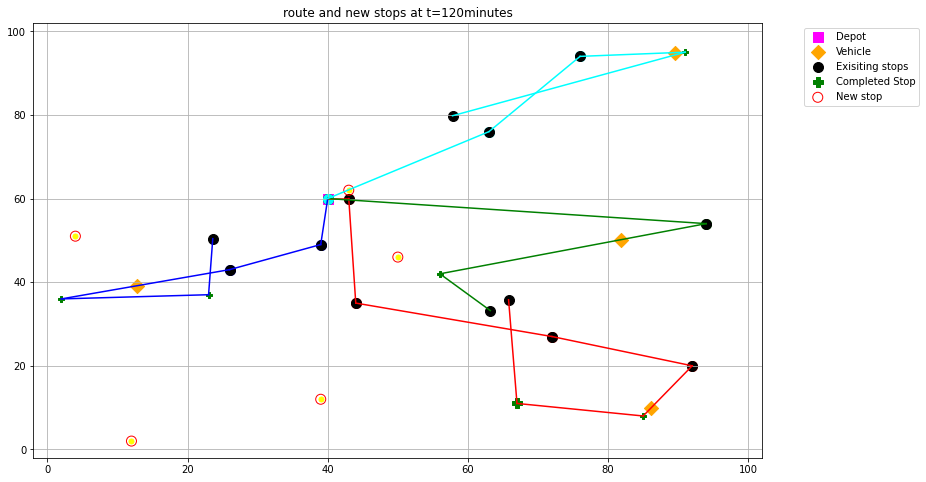

(19, 19)
Route for vehicle 0:
 1 ->  5 ->  11 ->  12 ->  6 ->  7 -> 0
Distance of the route: 136m

Route for vehicle 1:
 2 ->  15 ->  17 ->  16 -> 0
Distance of the route: 163m

Route for vehicle 2:
 3 ->  10 ->  18 -> 0
Distance of the route: 92m

Route for vehicle 3:
 4 ->  13 ->  9 ->  14 ->  8 -> 0
Distance of the route: 84m

Maximum of the route distances: 163m
0 red [1, 5, 11, 12, 6, 7, 0]
1 blue [2, 15, 17, 16, 0]
2 green [3, 10, 18, 0]
3 cyan [4, 13, 9, 14, 8, 0]


<Figure size 432x288 with 0 Axes>

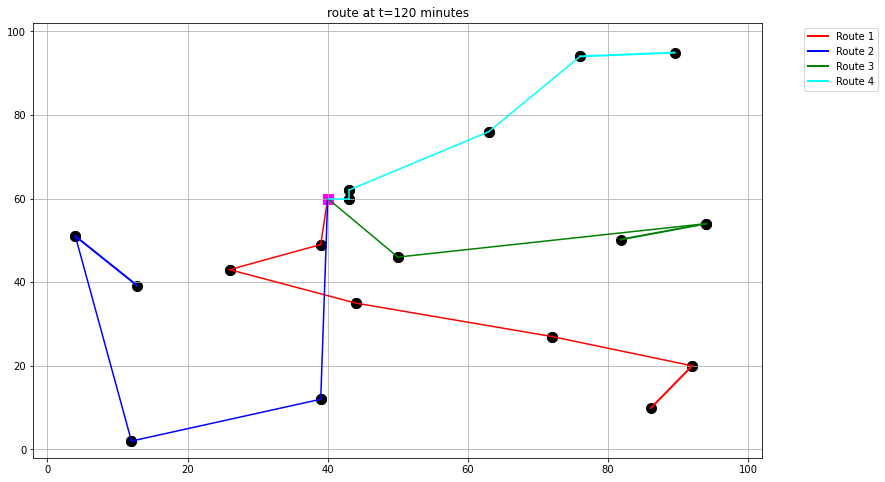

soln-at-time-125.png
0 red [1, 5, 11, 12, 6, 7, 0]
1 blue [2, 15, 17, 16, 0]
2 green [3, 10, 18, 0]
3 cyan [4, 13, 9, 14, 8, 0]


<Figure size 432x288 with 0 Axes>

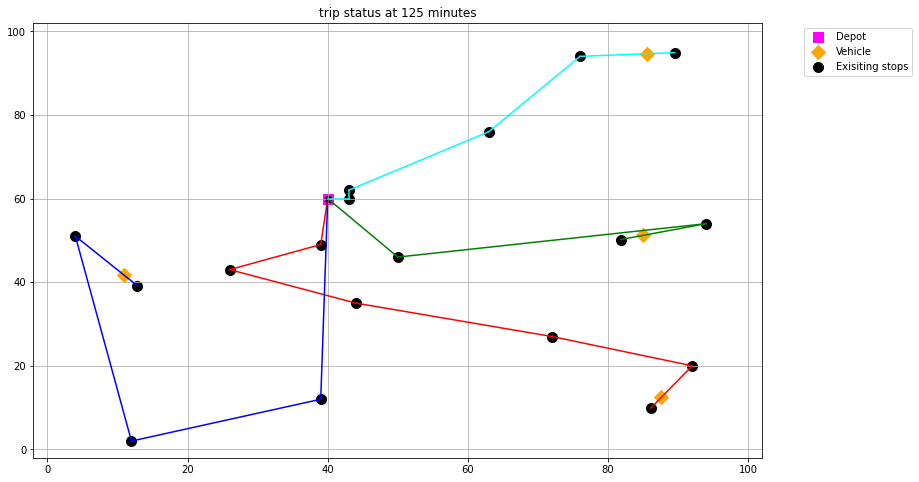

soln-at-time-130.png
0 red [1, 5, 11, 12, 6, 7, 0]
1 blue [2, 15, 17, 16, 0]
2 green [3, 10, 18, 0]
3 cyan [4, 13, 9, 14, 8, 0]


<Figure size 432x288 with 0 Axes>

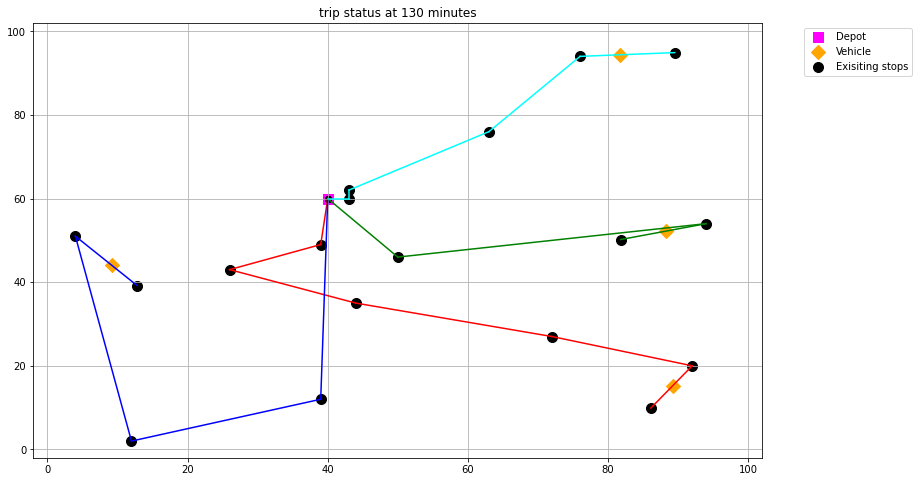

soln-at-time-135.png
0 red [1, 5, 11, 12, 6, 7, 0]
1 blue [2, 15, 17, 16, 0]
2 green [3, 10, 18, 0]
3 cyan [4, 13, 9, 14, 8, 0]


<Figure size 432x288 with 0 Axes>

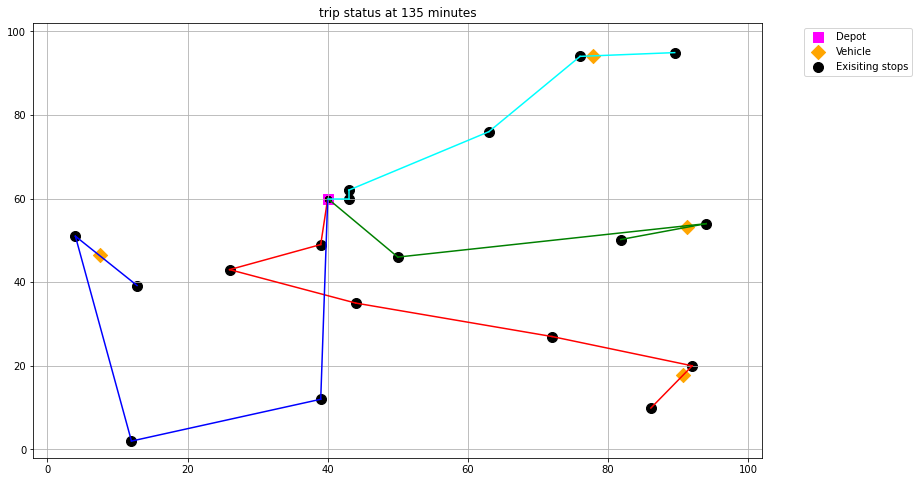

soln-at-time-140.png
0 red [1, 5, 11, 12, 6, 7, 0]
1 blue [2, 15, 17, 16, 0]
2 green [3, 10, 18, 0]
3 cyan [4, 13, 9, 14, 8, 0]


<Figure size 432x288 with 0 Axes>

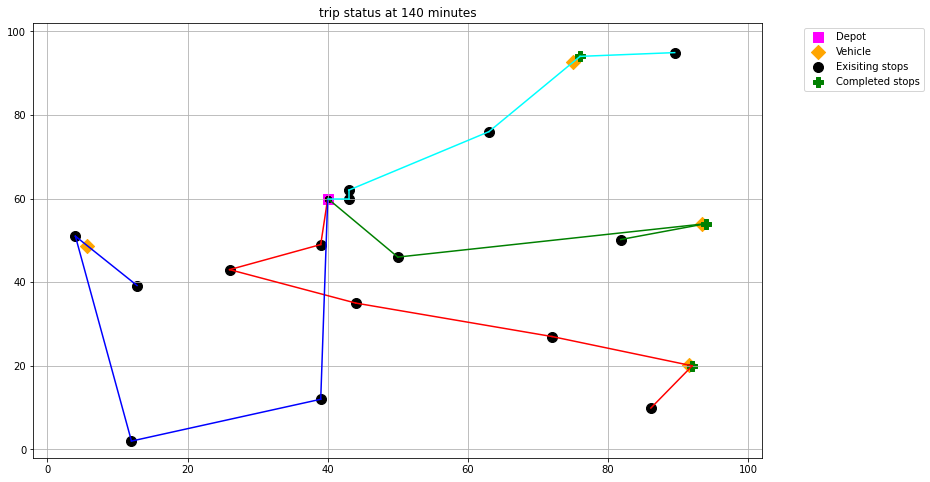

soln-at-time-145.png
0 red [1, 5, 11, 12, 6, 7, 0]
1 blue [2, 15, 17, 16, 0]
2 green [3, 10, 18, 0]
3 cyan [4, 13, 9, 14, 8, 0]


<Figure size 432x288 with 0 Axes>

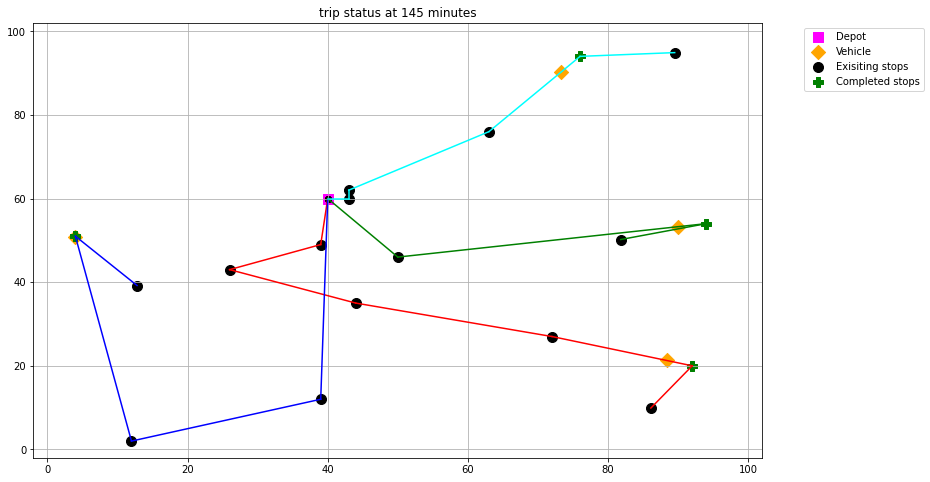

soln-at-time-150.png
0 red [1, 5, 11, 12, 6, 7, 0]
1 blue [2, 15, 17, 16, 0]
2 green [3, 10, 18, 0]
3 cyan [4, 13, 9, 14, 8, 0]


<Figure size 432x288 with 0 Axes>

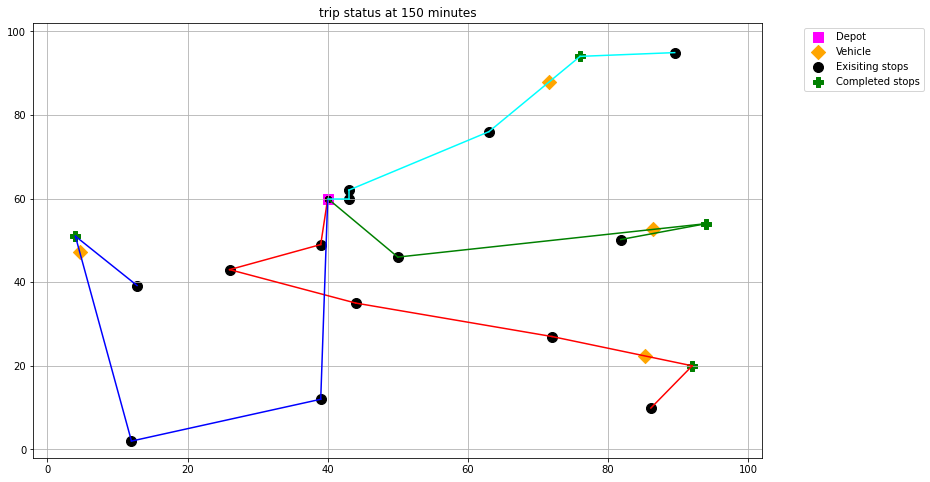

soln-at-time-155.png
0 red [1, 5, 11, 12, 6, 7, 0]
1 blue [2, 15, 17, 16, 0]
2 green [3, 10, 18, 0]
3 cyan [4, 13, 9, 14, 8, 0]


<Figure size 432x288 with 0 Axes>

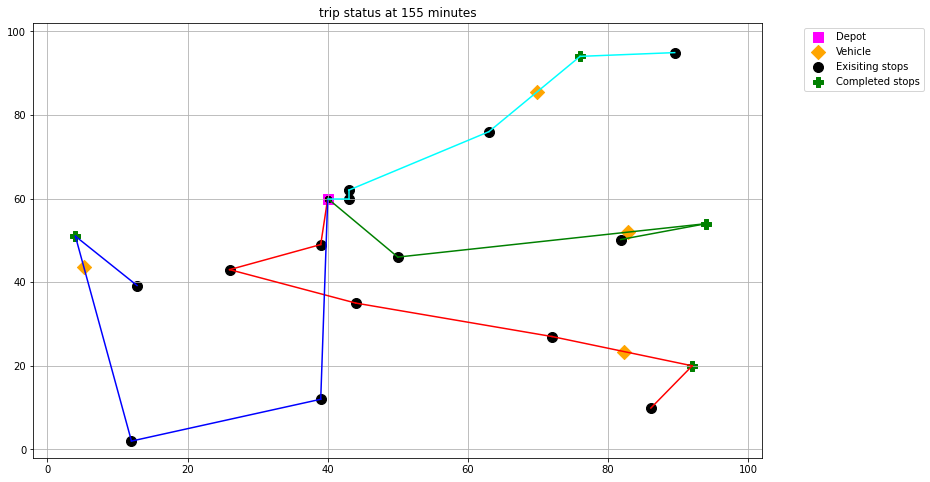

soln-at-time-160.png
0 red [1, 5, 11, 12, 6, 7, 0]
1 blue [2, 15, 17, 16, 0]
2 green [3, 10, 18, 0]
3 cyan [4, 13, 9, 14, 8, 0]


<Figure size 432x288 with 0 Axes>

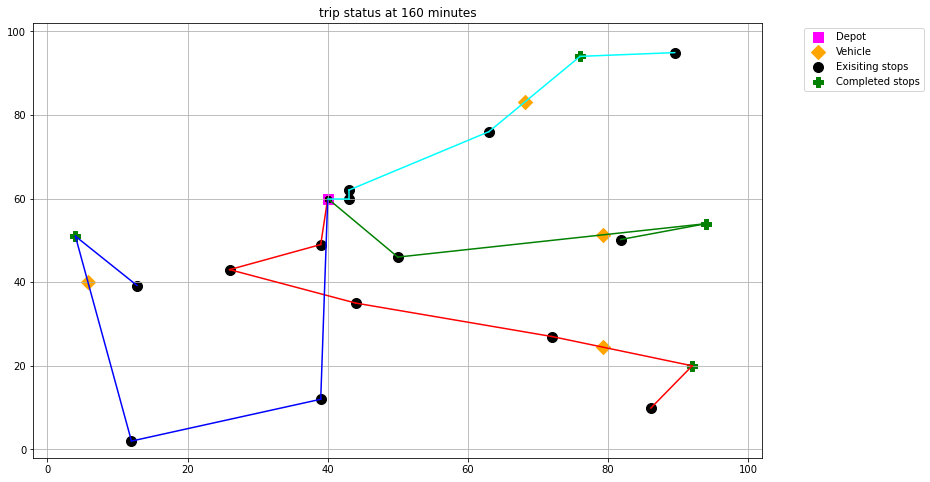

soln-at-time-165.png
0 red [1, 5, 11, 12, 6, 7, 0]
1 blue [2, 15, 17, 16, 0]
2 green [3, 10, 18, 0]
3 cyan [4, 13, 9, 14, 8, 0]


<Figure size 432x288 with 0 Axes>

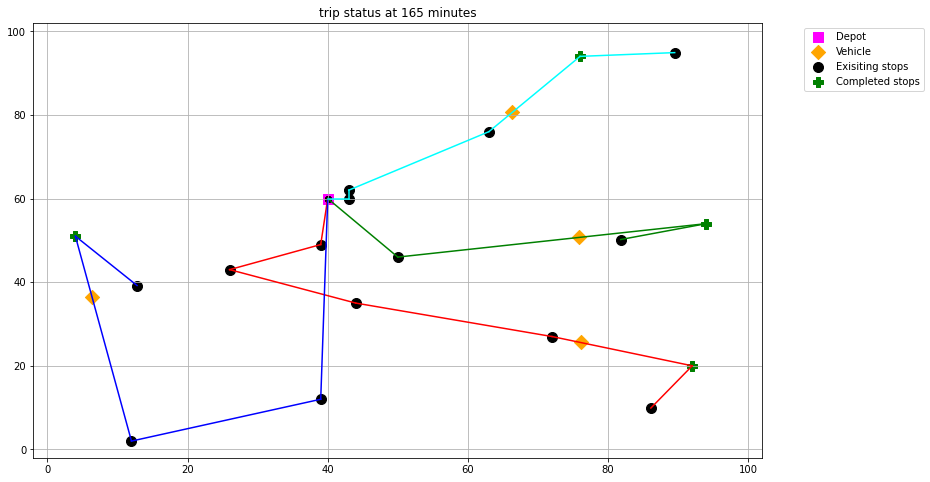

soln-at-time-170.png
0 red [1, 5, 11, 12, 6, 7, 0]
1 blue [2, 15, 17, 16, 0]
2 green [3, 10, 18, 0]
3 cyan [4, 13, 9, 14, 8, 0]


<Figure size 432x288 with 0 Axes>

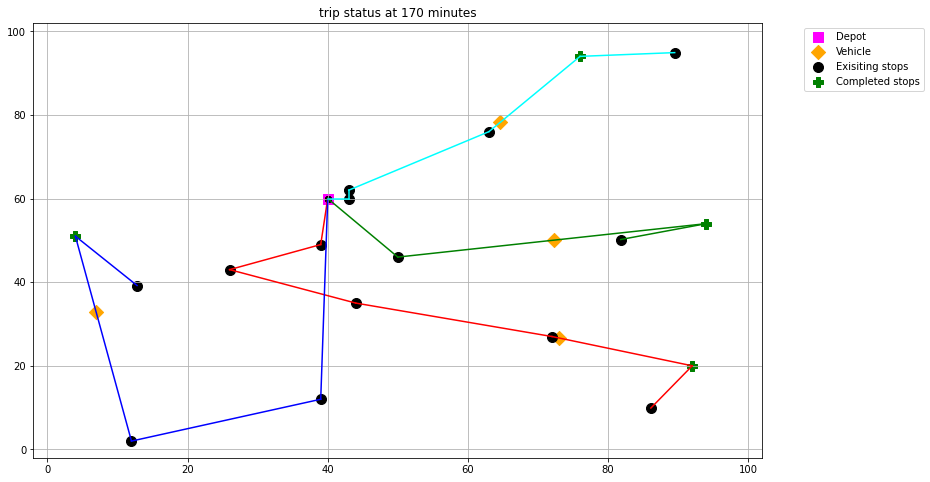

soln-at-time-175.png
0 red [1, 5, 11, 12, 6, 7, 0]
1 blue [2, 15, 17, 16, 0]
2 green [3, 10, 18, 0]
3 cyan [4, 13, 9, 14, 8, 0]


<Figure size 432x288 with 0 Axes>

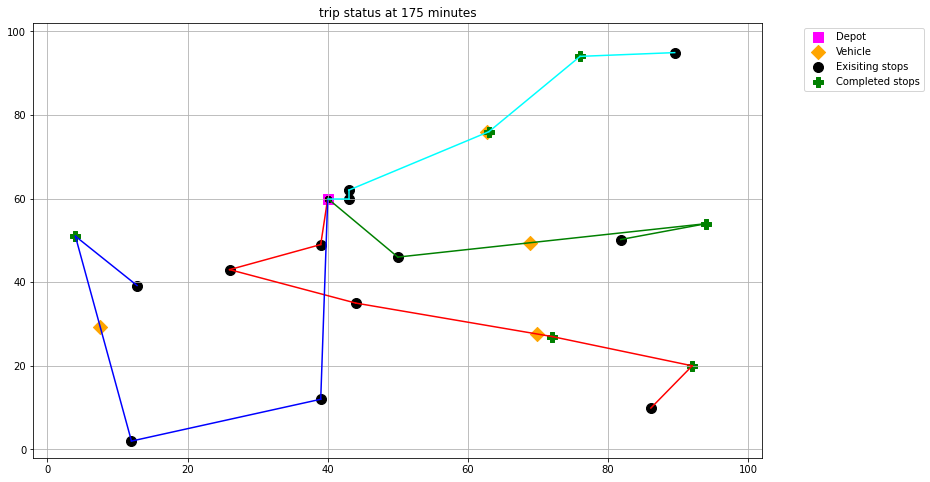

soln-at-time-180.png
0 red [1, 5, 11, 12, 6, 7, 0]
1 blue [2, 15, 17, 16, 0]
2 green [3, 10, 18, 0]
3 cyan [4, 13, 9, 14, 8, 0]


<Figure size 432x288 with 0 Axes>

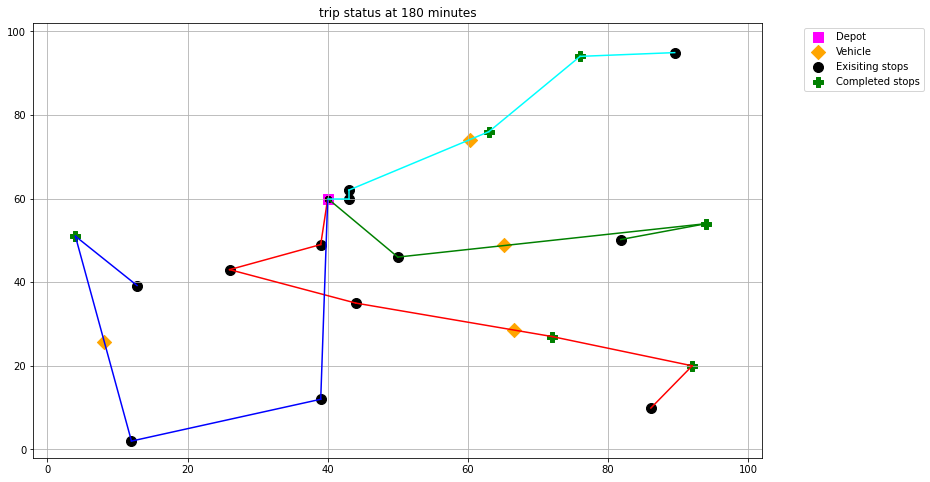

0 red [1, 5, 11, 12, 6, 7, 0]
1 blue [2, 15, 17, 16, 0]
2 green [3, 10, 18, 0]
3 cyan [4, 13, 9, 14, 8, 0]


<Figure size 432x288 with 0 Axes>

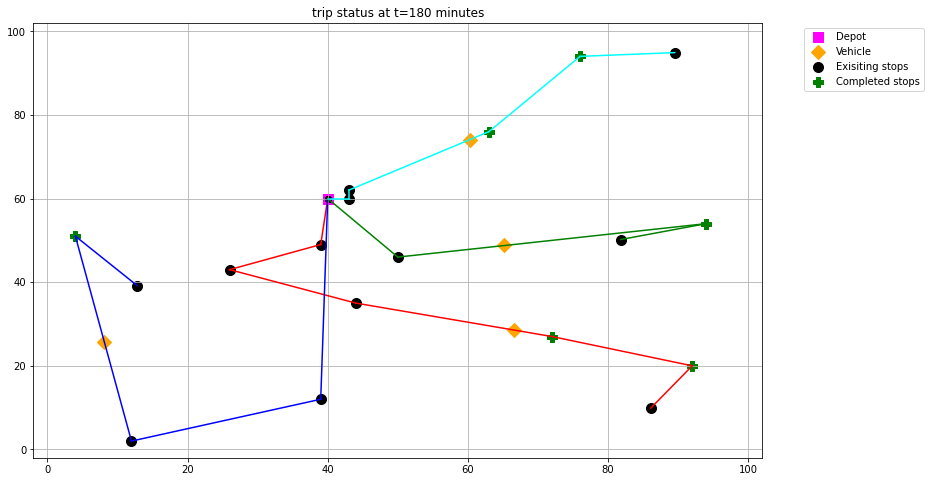

18
0 red [1, 5, 11, 12, 6, 7, 0]
1 blue [2, 15, 17, 16, 0]
2 green [3, 10, 18, 0]
3 cyan [4, 13, 9, 14, 8, 0]


<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

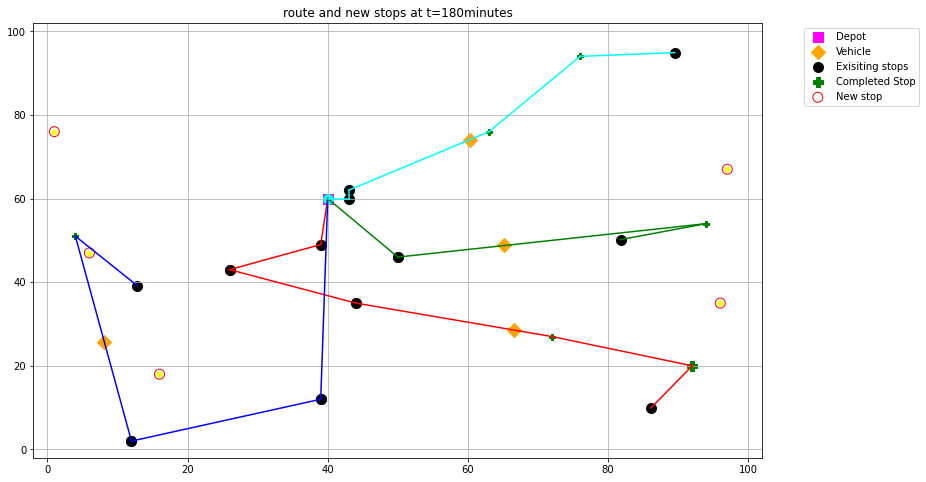

(18, 18)
Route for vehicle 0:
 1 ->  16 ->  14 ->  9 -> 0
Distance of the route: 132m

Route for vehicle 1:
 2 ->  15 ->  11 ->  10 ->  8 ->  7 -> 0
Distance of the route: 129m

Route for vehicle 2:
 3 ->  12 ->  5 ->  17 ->  6 -> 0
Distance of the route: 116m

Route for vehicle 3:
 4 ->  13 -> 0
Distance of the route: 116m

Maximum of the route distances: 132m
0 red [1, 16, 14, 9, 0]
1 blue [2, 15, 11, 10, 8, 7, 0]
2 green [3, 12, 5, 17, 6, 0]
3 cyan [4, 13, 0]


<Figure size 432x288 with 0 Axes>

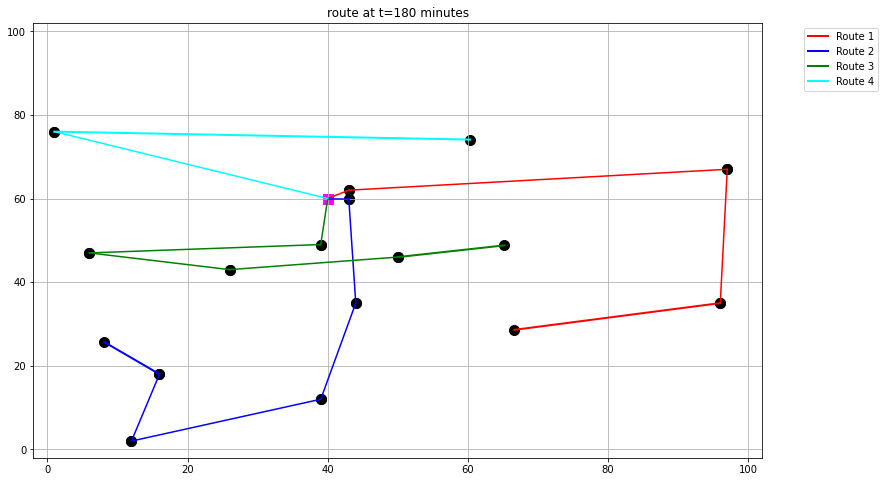

soln-at-time-185.png
0 red [1, 16, 14, 9, 0]
1 blue [2, 15, 11, 10, 8, 7, 0]
2 green [3, 12, 5, 17, 6, 0]
3 cyan [4, 13, 0]


<Figure size 432x288 with 0 Axes>

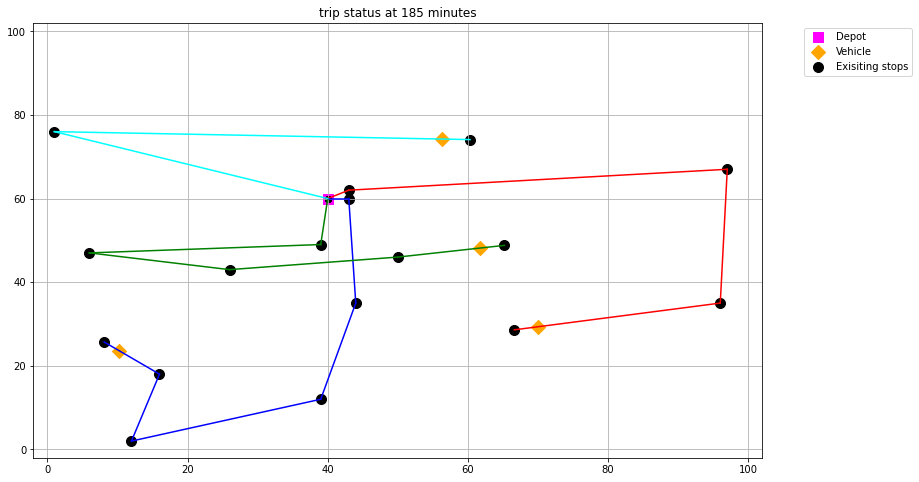

soln-at-time-190.png
0 red [1, 16, 14, 9, 0]
1 blue [2, 15, 11, 10, 8, 7, 0]
2 green [3, 12, 5, 17, 6, 0]
3 cyan [4, 13, 0]


<Figure size 432x288 with 0 Axes>

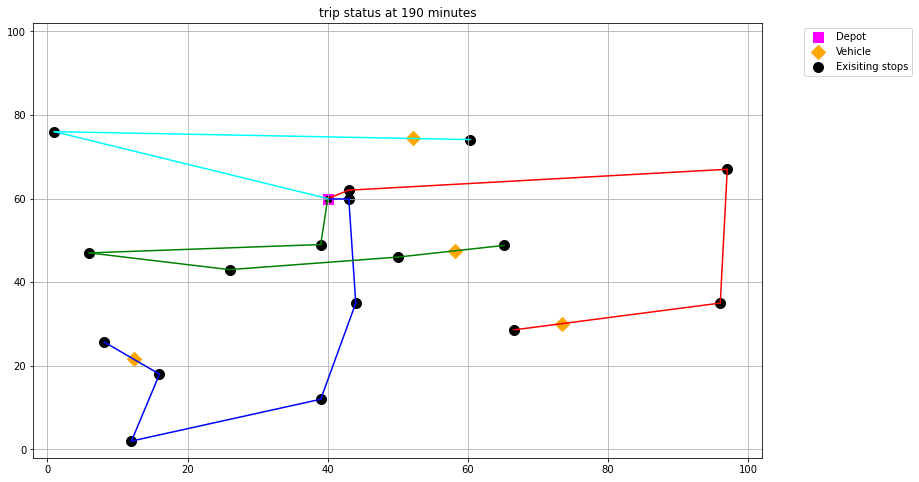

soln-at-time-195.png
0 red [1, 16, 14, 9, 0]
1 blue [2, 15, 11, 10, 8, 7, 0]
2 green [3, 12, 5, 17, 6, 0]
3 cyan [4, 13, 0]


<Figure size 432x288 with 0 Axes>

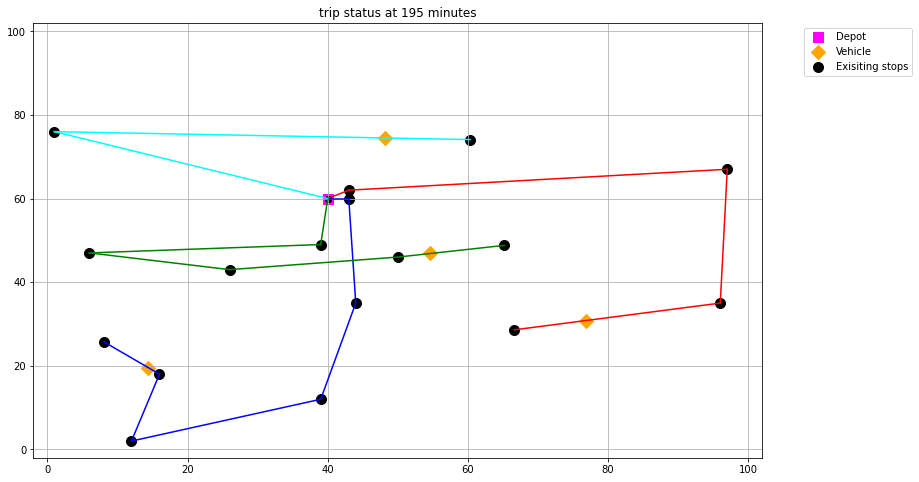

soln-at-time-200.png
0 red [1, 16, 14, 9, 0]
1 blue [2, 15, 11, 10, 8, 7, 0]
2 green [3, 12, 5, 17, 6, 0]
3 cyan [4, 13, 0]


<Figure size 432x288 with 0 Axes>

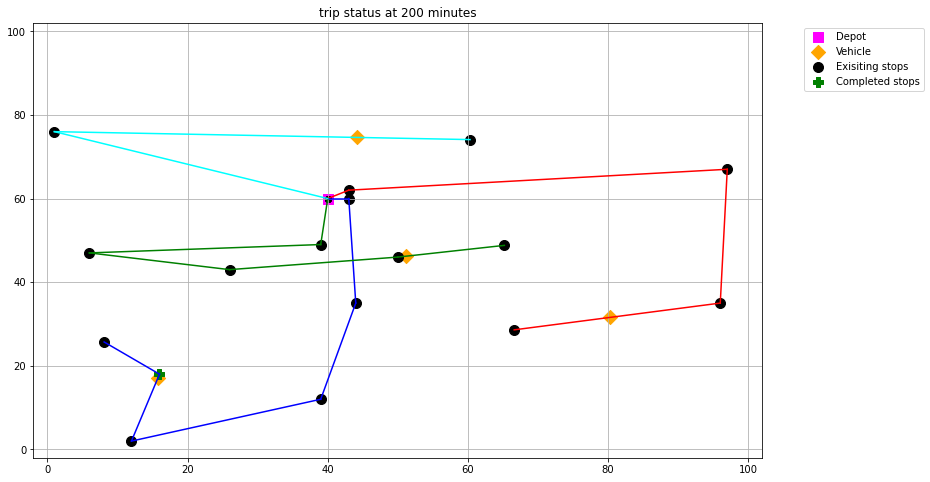

soln-at-time-205.png
0 red [1, 16, 14, 9, 0]
1 blue [2, 15, 11, 10, 8, 7, 0]
2 green [3, 12, 5, 17, 6, 0]
3 cyan [4, 13, 0]


<Figure size 432x288 with 0 Axes>

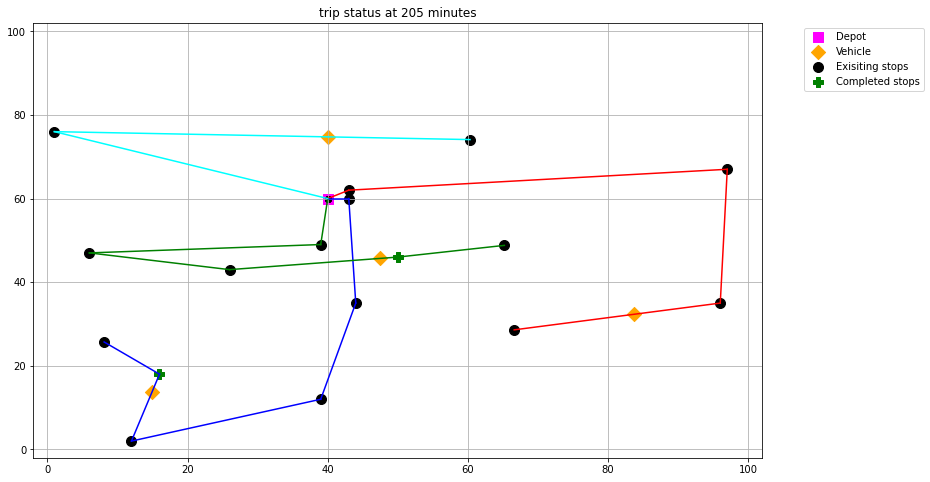

soln-at-time-210.png
0 red [1, 16, 14, 9, 0]
1 blue [2, 15, 11, 10, 8, 7, 0]
2 green [3, 12, 5, 17, 6, 0]
3 cyan [4, 13, 0]


<Figure size 432x288 with 0 Axes>

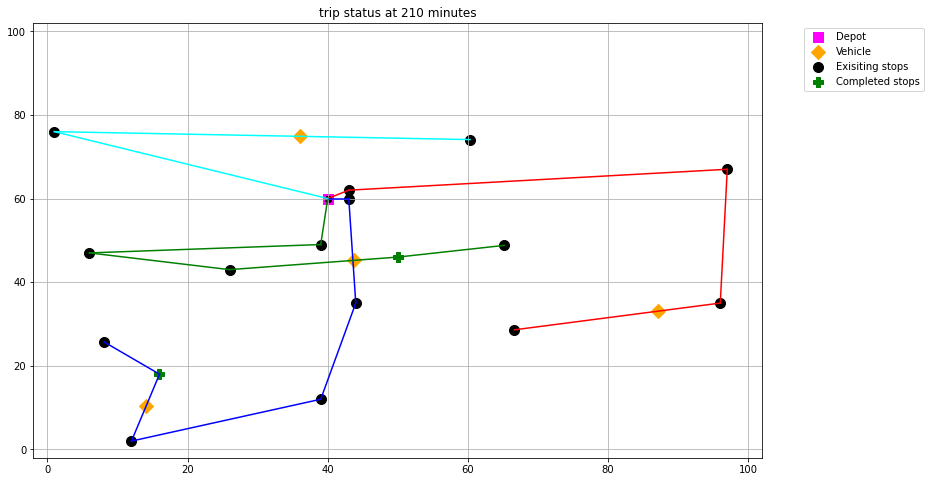

soln-at-time-215.png
0 red [1, 16, 14, 9, 0]
1 blue [2, 15, 11, 10, 8, 7, 0]
2 green [3, 12, 5, 17, 6, 0]
3 cyan [4, 13, 0]


<Figure size 432x288 with 0 Axes>

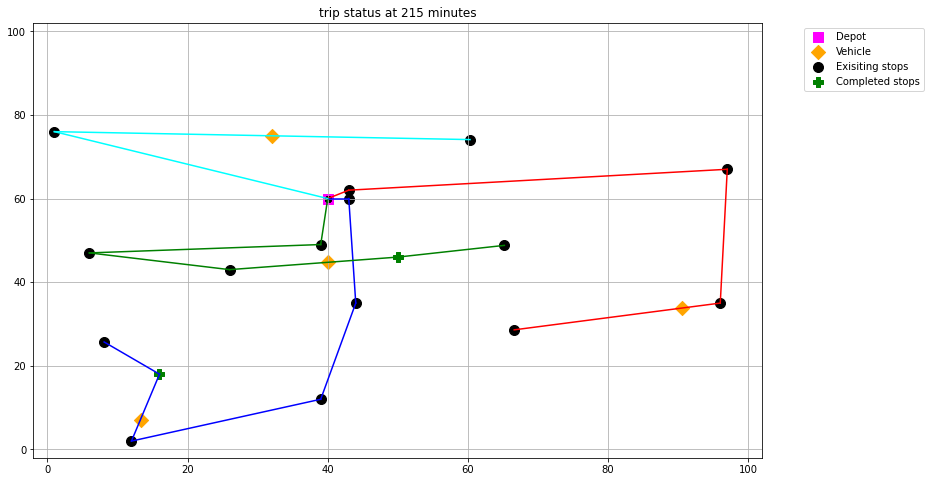

soln-at-time-220.png
0 red [1, 16, 14, 9, 0]
1 blue [2, 15, 11, 10, 8, 7, 0]
2 green [3, 12, 5, 17, 6, 0]
3 cyan [4, 13, 0]


<Figure size 432x288 with 0 Axes>

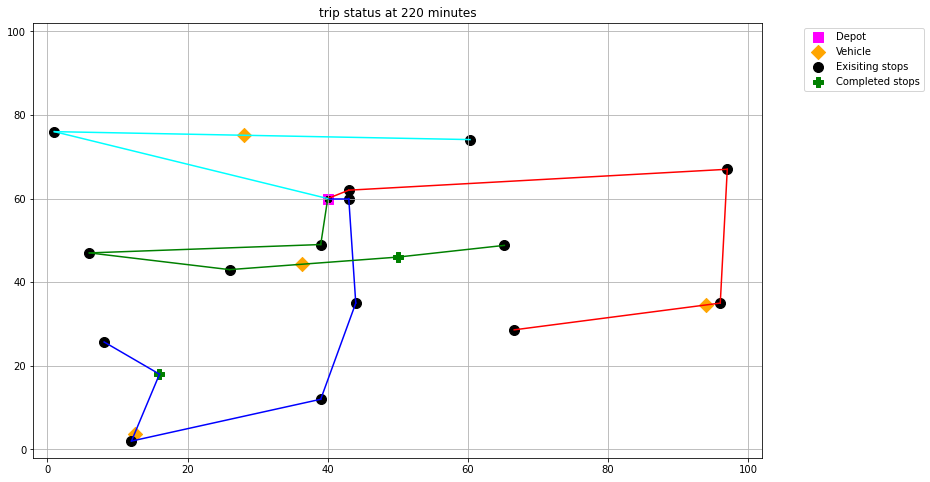

soln-at-time-225.png
0 red [1, 16, 14, 9, 0]
1 blue [2, 15, 11, 10, 8, 7, 0]
2 green [3, 12, 5, 17, 6, 0]
3 cyan [4, 13, 0]


<Figure size 432x288 with 0 Axes>

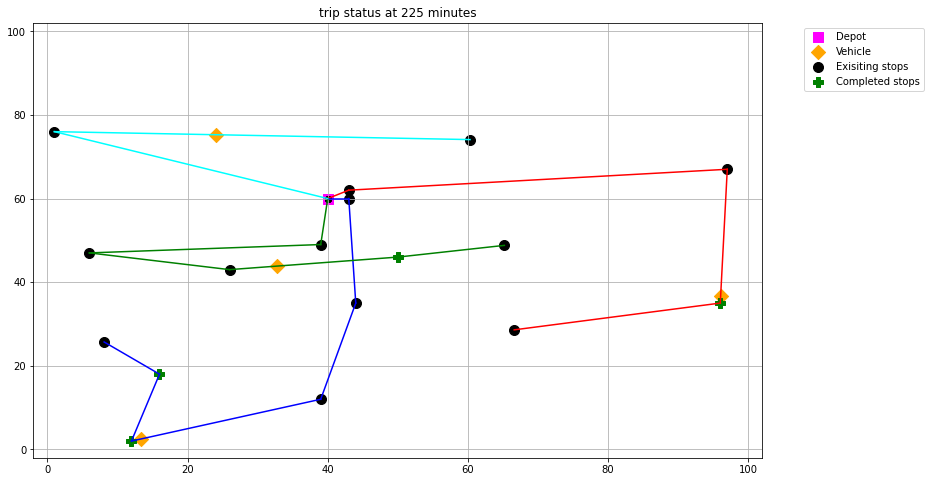

soln-at-time-230.png
0 red [1, 16, 14, 9, 0]
1 blue [2, 15, 11, 10, 8, 7, 0]
2 green [3, 12, 5, 17, 6, 0]
3 cyan [4, 13, 0]


<Figure size 432x288 with 0 Axes>

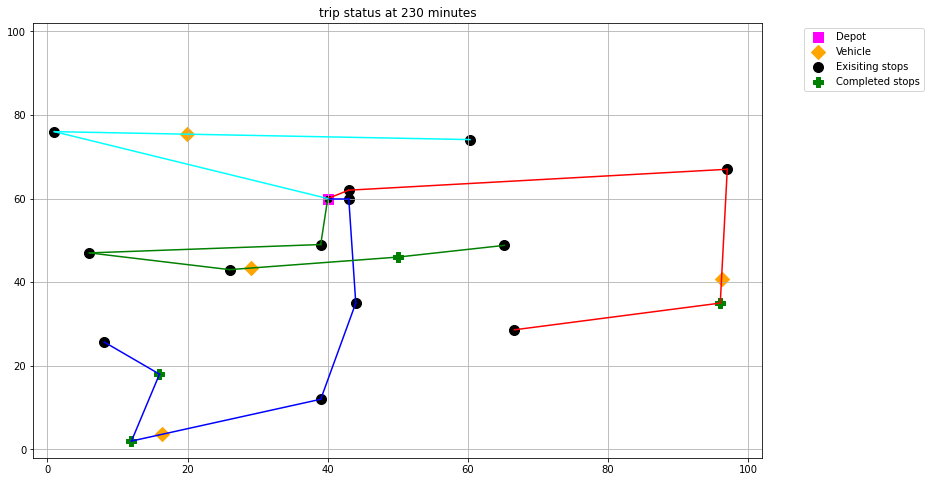

soln-at-time-235.png
0 red [1, 16, 14, 9, 0]
1 blue [2, 15, 11, 10, 8, 7, 0]
2 green [3, 12, 5, 17, 6, 0]
3 cyan [4, 13, 0]


<Figure size 432x288 with 0 Axes>

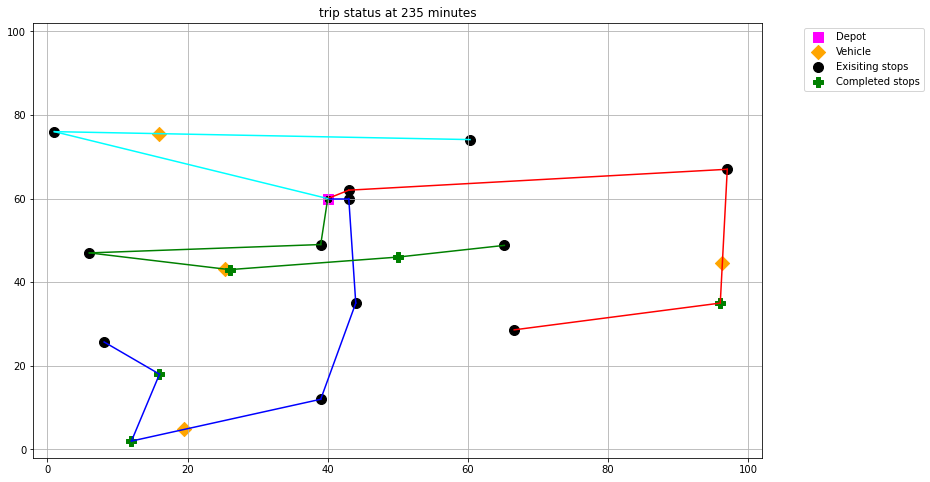

soln-at-time-240.png
0 red [1, 16, 14, 9, 0]
1 blue [2, 15, 11, 10, 8, 7, 0]
2 green [3, 12, 5, 17, 6, 0]
3 cyan [4, 13, 0]


<Figure size 432x288 with 0 Axes>

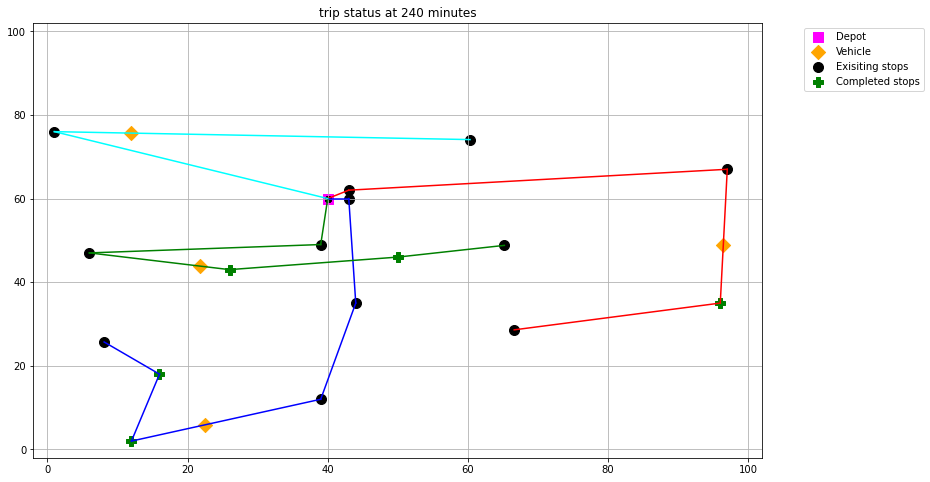

0 red [1, 16, 14, 9, 0]
1 blue [2, 15, 11, 10, 8, 7, 0]
2 green [3, 12, 5, 17, 6, 0]
3 cyan [4, 13, 0]


<Figure size 432x288 with 0 Axes>

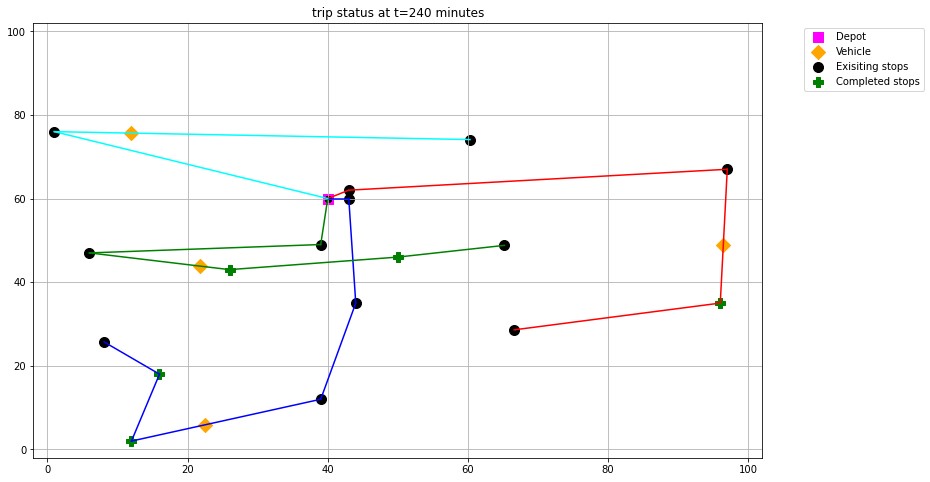

18
0 red [1, 16, 14, 9, 0]
1 blue [2, 15, 11, 10, 8, 7, 0]
2 green [3, 12, 5, 17, 6, 0]
3 cyan [4, 13, 0]


<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

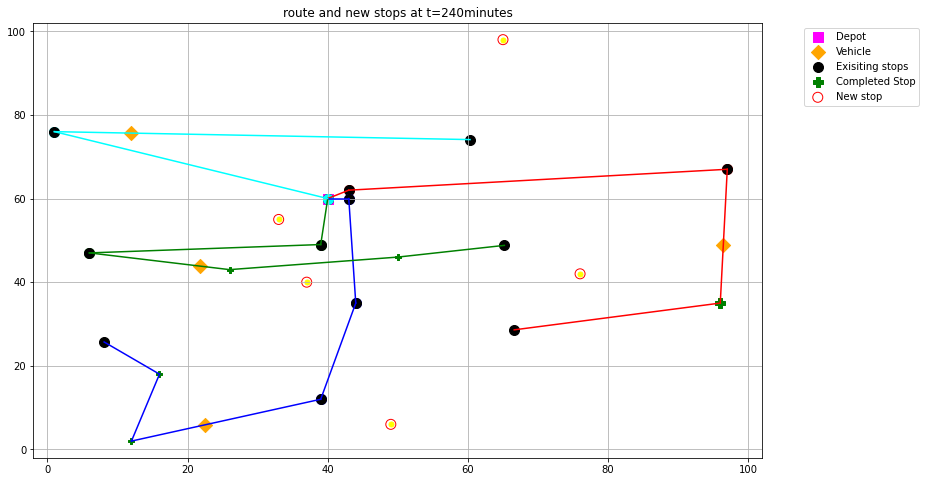

(18, 18)
Route for vehicle 0:
 1 ->  11 ->  16 ->  8 ->  6 -> 0
Distance of the route: 144m

Route for vehicle 1:
 2 ->  17 ->  9 ->  7 ->  5 -> 0
Distance of the route: 101m

Route for vehicle 2:
 3 ->  14 ->  13 -> 0
Distance of the route: 113m

Route for vehicle 3:
 4 ->  10 ->  12 ->  15 -> 0
Distance of the route: 92m

Maximum of the route distances: 144m
0 red [1, 11, 16, 8, 6, 0]
1 blue [2, 17, 9, 7, 5, 0]
2 green [3, 14, 13, 0]
3 cyan [4, 10, 12, 15, 0]


<Figure size 432x288 with 0 Axes>

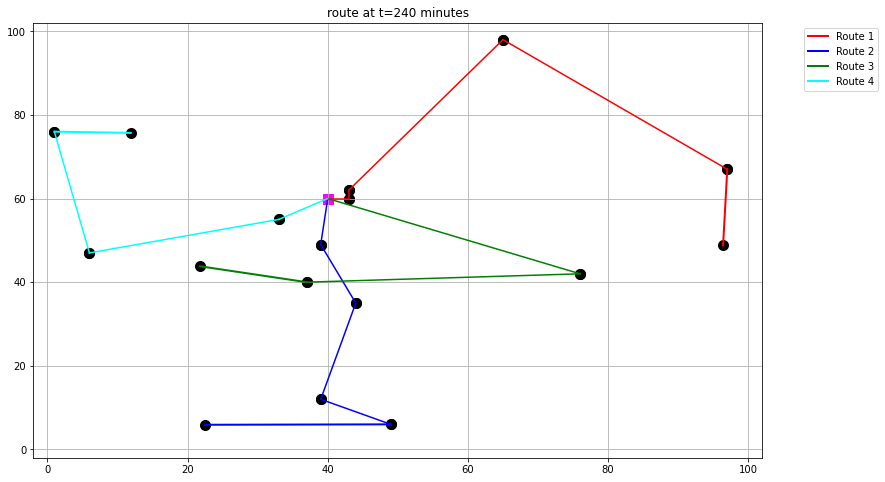

soln-at-time-245.png
0 red [1, 11, 16, 8, 6, 0]
1 blue [2, 17, 9, 7, 5, 0]
2 green [3, 14, 13, 0]
3 cyan [4, 10, 12, 15, 0]


<Figure size 432x288 with 0 Axes>

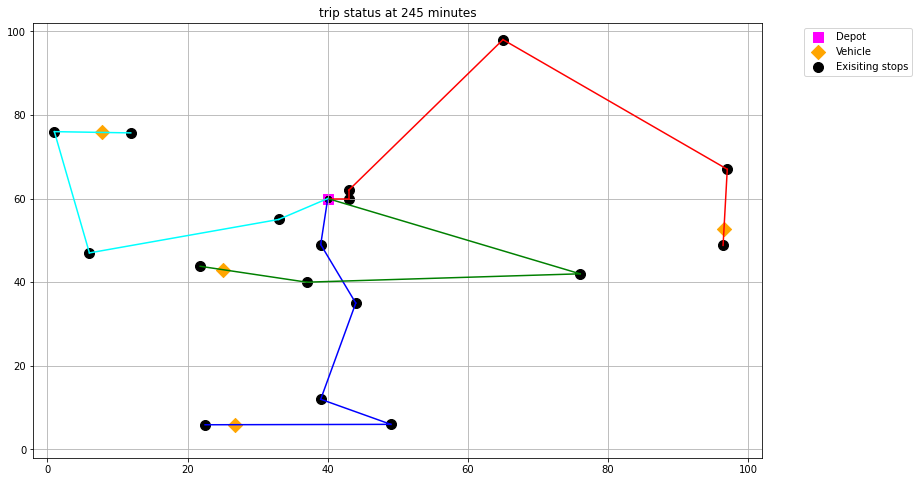

soln-at-time-250.png
0 red [1, 11, 16, 8, 6, 0]
1 blue [2, 17, 9, 7, 5, 0]
2 green [3, 14, 13, 0]
3 cyan [4, 10, 12, 15, 0]


<Figure size 432x288 with 0 Axes>

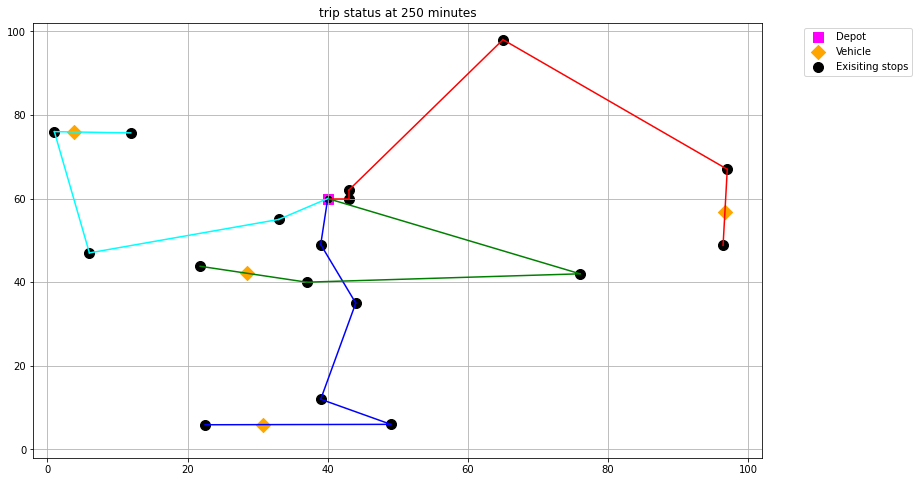

soln-at-time-255.png
0 red [1, 11, 16, 8, 6, 0]
1 blue [2, 17, 9, 7, 5, 0]
2 green [3, 14, 13, 0]
3 cyan [4, 10, 12, 15, 0]


<Figure size 432x288 with 0 Axes>

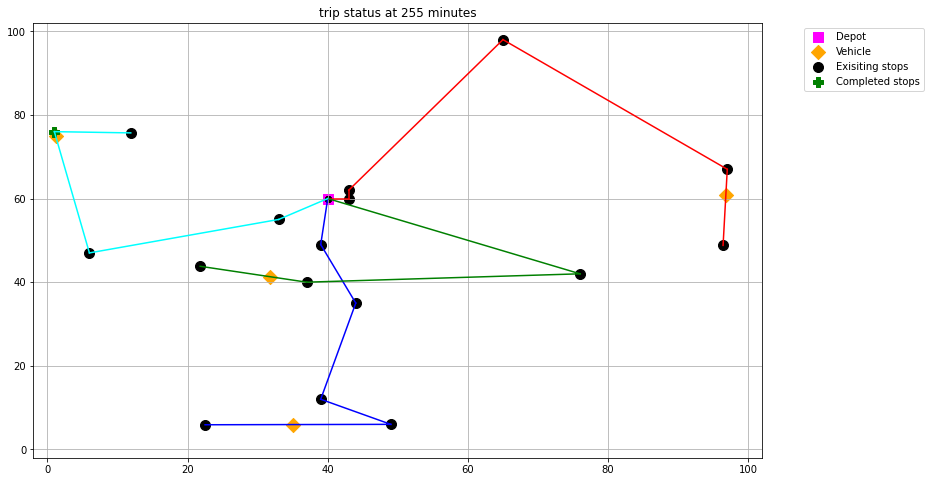

soln-at-time-260.png
0 red [1, 11, 16, 8, 6, 0]
1 blue [2, 17, 9, 7, 5, 0]
2 green [3, 14, 13, 0]
3 cyan [4, 10, 12, 15, 0]


<Figure size 432x288 with 0 Axes>

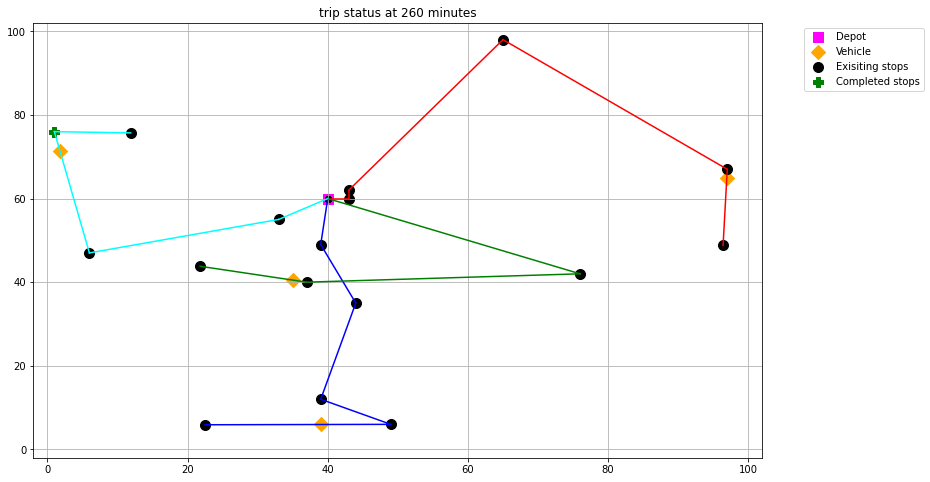

soln-at-time-265.png
0 red [1, 11, 16, 8, 6, 0]
1 blue [2, 17, 9, 7, 5, 0]
2 green [3, 14, 13, 0]
3 cyan [4, 10, 12, 15, 0]


<Figure size 432x288 with 0 Axes>

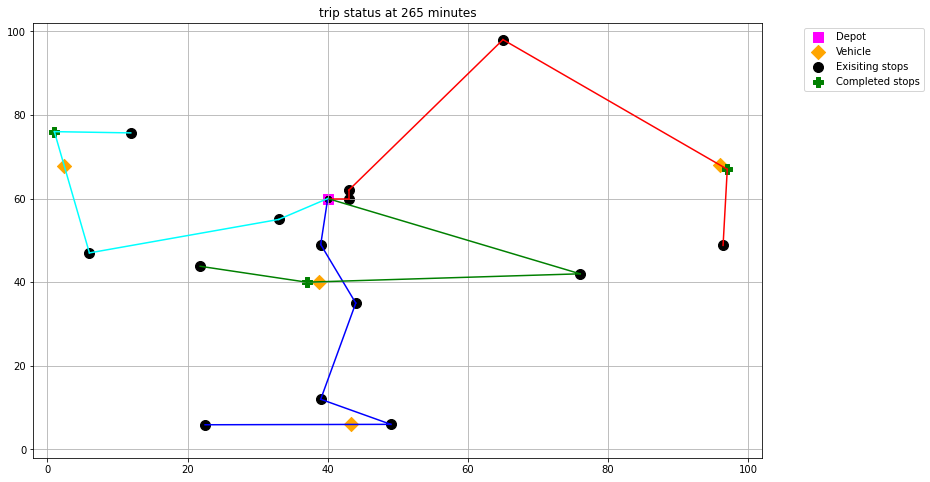

soln-at-time-270.png
0 red [1, 11, 16, 8, 6, 0]
1 blue [2, 17, 9, 7, 5, 0]
2 green [3, 14, 13, 0]
3 cyan [4, 10, 12, 15, 0]


<Figure size 432x288 with 0 Axes>

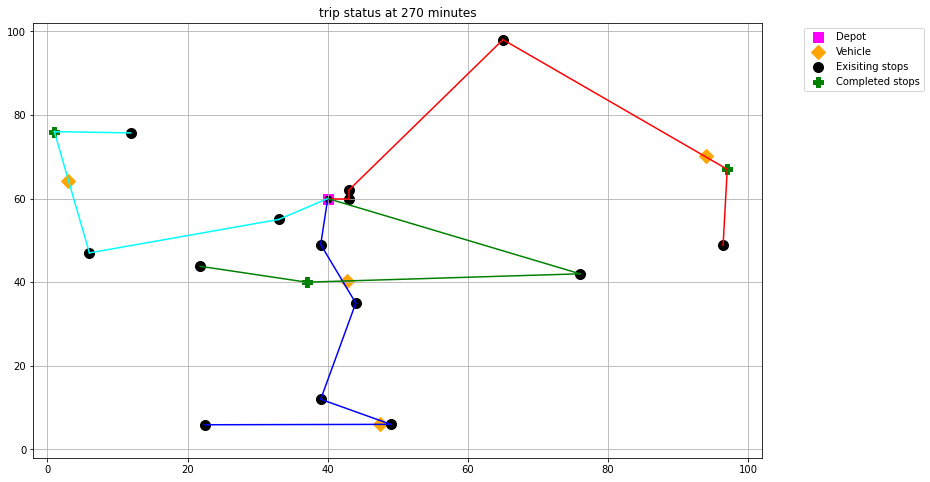

soln-at-time-275.png
0 red [1, 11, 16, 8, 6, 0]
1 blue [2, 17, 9, 7, 5, 0]
2 green [3, 14, 13, 0]
3 cyan [4, 10, 12, 15, 0]


<Figure size 432x288 with 0 Axes>

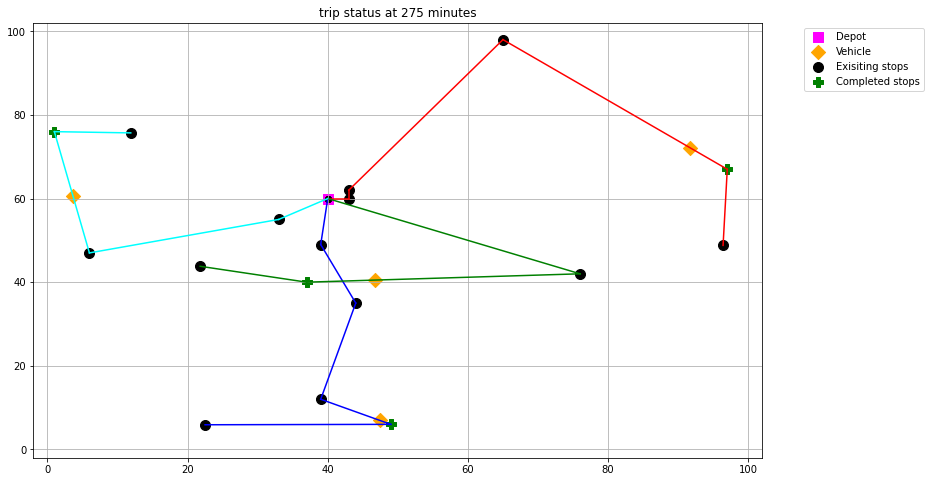

soln-at-time-280.png
0 red [1, 11, 16, 8, 6, 0]
1 blue [2, 17, 9, 7, 5, 0]
2 green [3, 14, 13, 0]
3 cyan [4, 10, 12, 15, 0]


<Figure size 432x288 with 0 Axes>

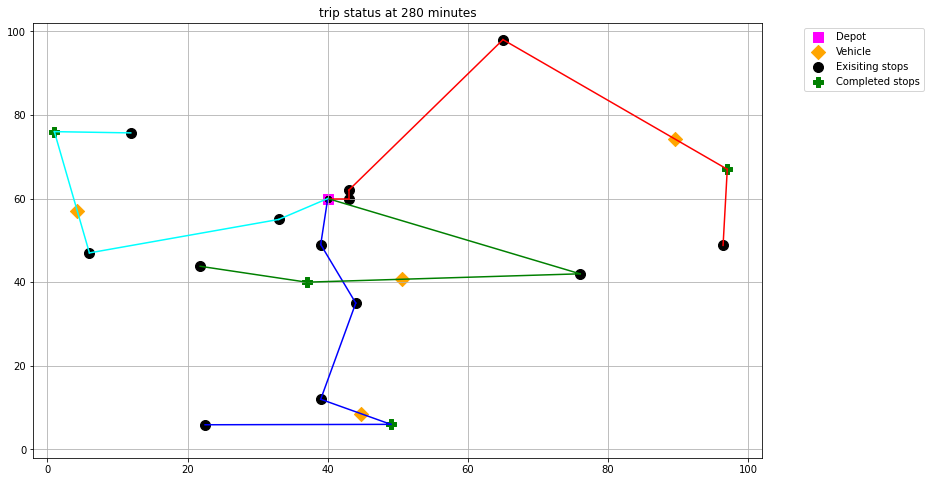

soln-at-time-285.png
0 red [1, 11, 16, 8, 6, 0]
1 blue [2, 17, 9, 7, 5, 0]
2 green [3, 14, 13, 0]
3 cyan [4, 10, 12, 15, 0]


<Figure size 432x288 with 0 Axes>

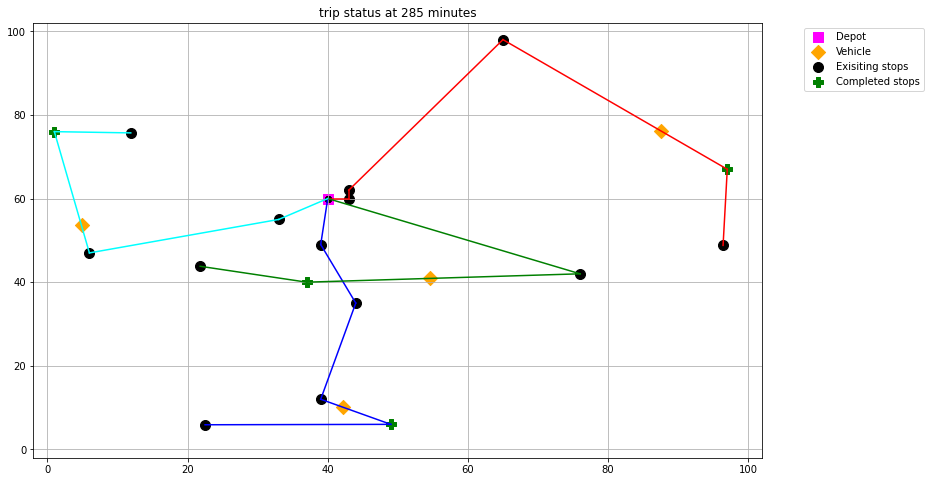

soln-at-time-290.png
0 red [1, 11, 16, 8, 6, 0]
1 blue [2, 17, 9, 7, 5, 0]
2 green [3, 14, 13, 0]
3 cyan [4, 10, 12, 15, 0]


<Figure size 432x288 with 0 Axes>

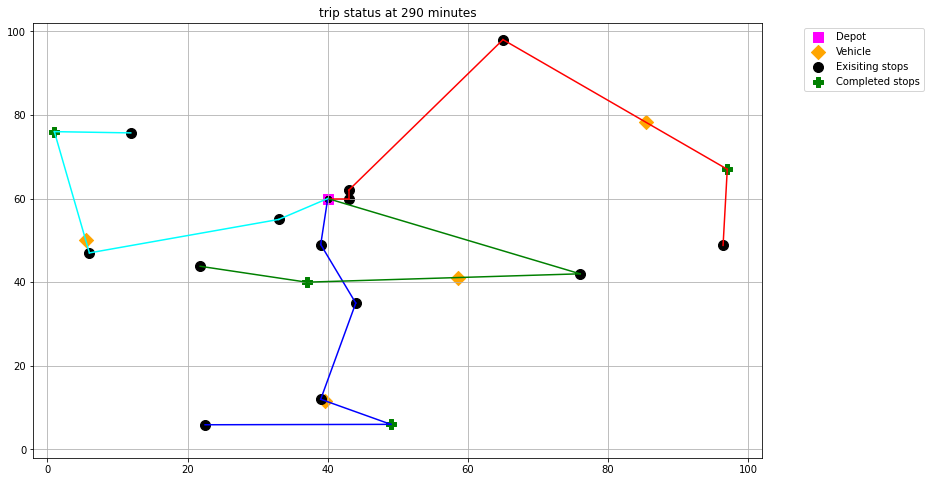

soln-at-time-295.png
0 red [1, 11, 16, 8, 6, 0]
1 blue [2, 17, 9, 7, 5, 0]
2 green [3, 14, 13, 0]
3 cyan [4, 10, 12, 15, 0]


<Figure size 432x288 with 0 Axes>

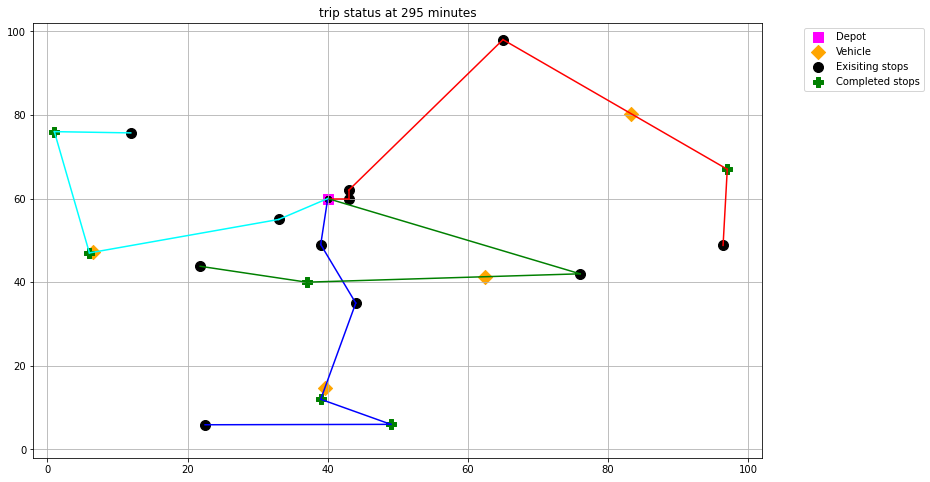

soln-at-time-300.png
0 red [1, 11, 16, 8, 6, 0]
1 blue [2, 17, 9, 7, 5, 0]
2 green [3, 14, 13, 0]
3 cyan [4, 10, 12, 15, 0]


<Figure size 432x288 with 0 Axes>

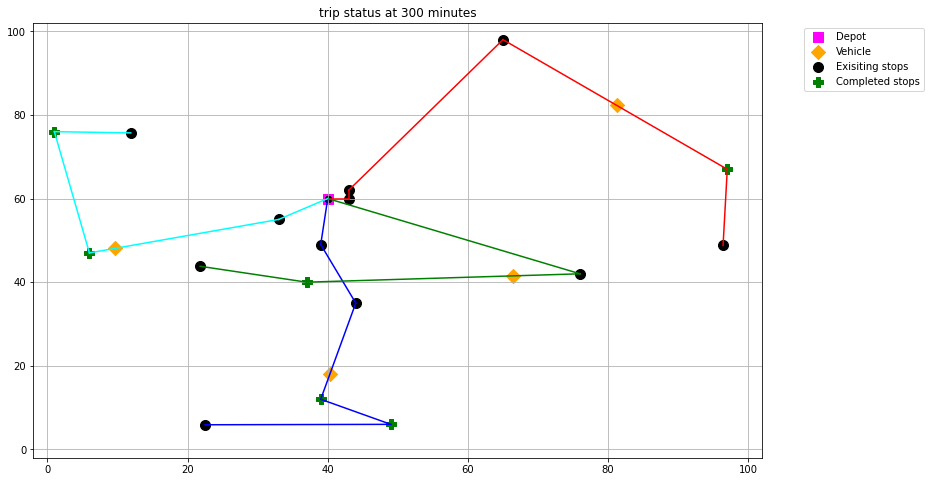

0 red [1, 11, 16, 8, 6, 0]
1 blue [2, 17, 9, 7, 5, 0]
2 green [3, 14, 13, 0]
3 cyan [4, 10, 12, 15, 0]


<Figure size 432x288 with 0 Axes>

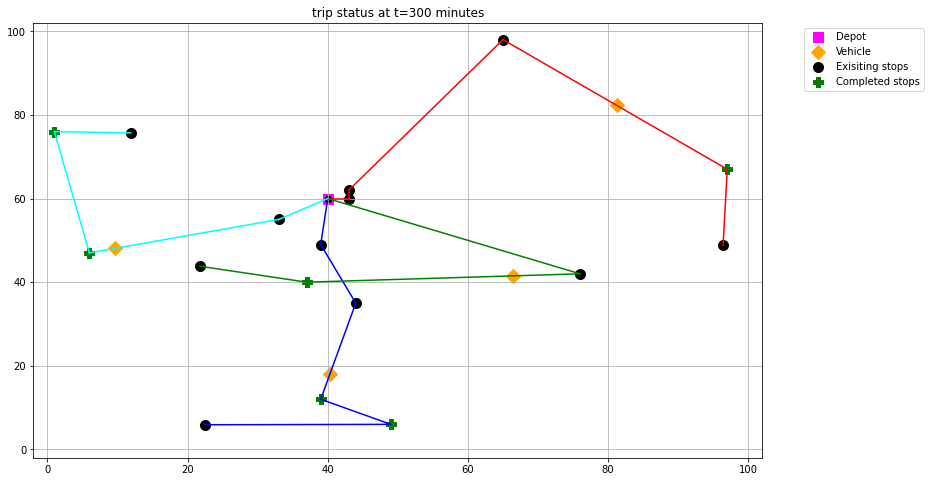

17
0 red [1, 11, 16, 8, 6, 0]
1 blue [2, 17, 9, 7, 5, 0]
2 green [3, 14, 13, 0]
3 cyan [4, 10, 12, 15, 0]


<Figure size 432x288 with 0 Axes>

<Figure size 1080x576 with 0 Axes>

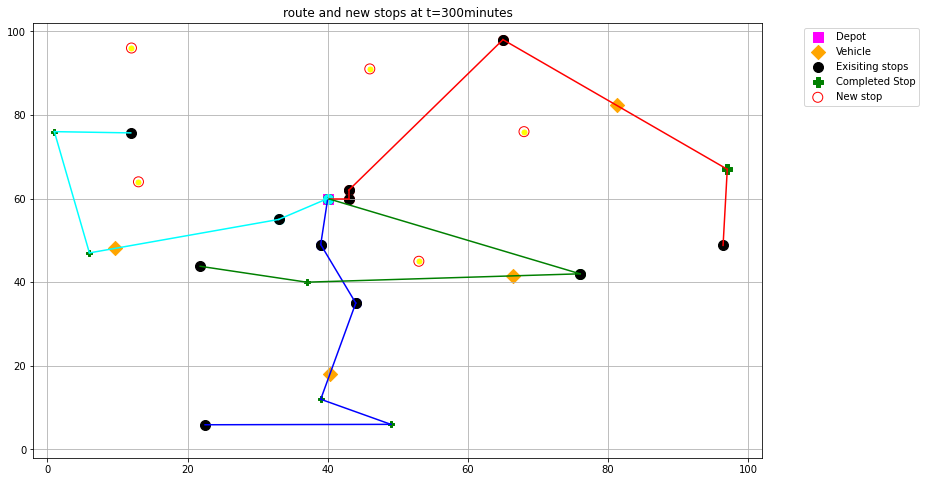

(17, 17)


<Figure size 432x288 with 0 Axes>

In [23]:
loopover()